In [1]:
import os
import pandas as pd
import numpy as np 
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.diagnostic import lilliefors
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, RocCurveDisplay, roc_auc_score, f1_score, PrecisionRecallDisplay

pd.set_option('display.width', 1000)

dfs = {} # initialise a dictionary to store data frames

def read_data(name_dir):
    
    for file in os.listdir(name_dir): # for each file in the specified directory
        
        if file.endswith(".csv"): # if the file is a csv
            
            # get the file name (in lower case)
            df_name = file.replace(".csv", "").lower()
            
            # create a dictionary key using the file's name, then read the csv and assign it to the key
            dfs[df_name] = pd.read_csv(os.path.join(name_dir, file)) 

In [2]:

# read in data frames
read_data("data/OULAD")

dfs.keys() # our data frames

dict_keys(['assessments', 'courses', 'studentassessment', 'studentinfo', 'studentregistration', 'studentvle', 'vle'])

##### Inspect data

In [3]:
for df_name, df in dfs.items():
    
    # print data frame name as header
    print("|" * 40, df_name, "|" * 40)
    
    # print row count, column counts and null counts
    print(f"""
Rows: {df.shape[0]}
Columns: {df.shape[1]}
Nulls: {df.isnull().sum().sum()} 
""")
    
    # print sample of 20 rows of data frame
    print("-" * 20, "Data Frame Sample", "-" * 20,"\n\n", f"{df.sample(20)}\n\n")
    
    # print .info() for data frame
    print("-" * 20, "Info", "-" * 20,"\n")
    df.info(show_counts = True)
    print("\n\n")
    
    # print .describe() for all columns, not just numeric
    print("-" * 20, "Descriptive Stats", "-" * 20,"\n\n", f"{df.describe(include = "all")}\n")
    
    print("-" * 20, "Unique Values (Object-type columns)", "-" * 20, "\n\n")
    
    # for each column in the data frame
    for col in df:
        
        # if the column is an object-type
        if df[col].dtype == "object":
            
            print(f"{col}: {df[col].unique()}\n") # print unique values
    
    print("\n\n\n")
    
initial_df_row_counts = {}
for df_name, df in dfs.items():
    initial_df_row_counts[df_name] = df.shape[0]
    
initial_df_row_counts

|||||||||||||||||||||||||||||||||||||||| assessments ||||||||||||||||||||||||||||||||||||||||

Rows: 206
Columns: 6
Nulls: 0 

-------------------- Data Frame Sample -------------------- 

     code_module code_presentation  id_assessment assessment_type date  weight
113         EEE             2013J          30713            Exam  235   100.0
102         DDD             2014J          25362             TMA   20     5.0
82          DDD             2013B          25335             TMA   53    10.0
64          CCC             2014J          24295             CMA   18     2.0
34          BBB             2013J          15001             TMA  208    18.0
78          DDD             2013B          25345             CMA  149     4.0
97          DDD             2014B          25357             TMA   74    17.5
86          DDD             2013B          25339             TMA  200    15.0
60          CCC             2014B          24284             TMA  151    22.0
15          BBB             20

{'assessments': 206,
 'courses': 22,
 'studentassessment': 173912,
 'studentinfo': 32593,
 'studentregistration': 32593,
 'studentvle': 10655280,
 'vle': 6364}

**Initial thoughts/observations (with help from: Kuzilek, Hlosta & Zdrahal, 2017):**

Overall
 - No null values!
 - "Date" is measured as number of days relative to module/presentation start date
   - Can't determine the actual dates these refer to!

assessments
 - code_module
   - 7 unique modules
 - code_presentation
   - Each module has a "B" presentation (starting in February) and a "J" presentation (starting in October), each for the years 2013 and 2014 respectively
 - id_assessment 
   - <strong> <u> uniquely identifies each assessment </u> </strong>
 - assessment_type
   - 3 assessment types (Exam, TMA, CMA)
 - date
   - should be integer (positive or negative) but has "?" as value
     - <strong> <u> Can't outright remove since these refer to assessments, but need to be excluded when working with the dates from this data set </u> </strong>
 - weight
   - assessment weight towards overall grade
   -  <strong> <u> has minimum of 0 </u> </strong>
      -  Suggests some assessments do not contribute towards overall grade. 
      -  These may or may not be relevant for analyses - still keep them though!

courses
 - module_presentation_length
   - measured in days
   - range of 234 to 269 days seems reasonable

studentassessment
 - id_student
   - <strong> <u> unique student identifier (anonymised) </u> </strong>
 - date_submitted
   - date assessment was submitted by student, relative to start of module presentation
   - measured in days
   - <strong> <u> minimum is -11 </u> </strong>
     - suggests assessment was submitted before module was presented?
     - Could be reasonable, but seems wrong. Minimum should probably be 0 (which is still suspicious)
 - is_banked
   - "a status flag indicating that the assessment result has been transferred from a previous presentation"
   - date_submitted which are <u 0 might be flagged by this
     - This would explain why minimum for date_submitted is -11
 - score
   - should be data type int64, with range 0-100, but is actually an object
   - "?" appears in column 
     - <strong> <u> these "?" rows should be removed, not imputed with 0 </u> </strong>

studentinfo
 - gender 
   - just male (M) or female (F)
 - region
   - 13 unique regions
     - all UK & Ireland regions!
 - highest_education
   - all valid qualification categories
 - imd_band
   - "Index of Multiple Deprivation band"
   - <strong> <u> Has "?" rows, remove these when looking at imd_band </u> </strong>
 - age_band
   - only three categories, very low resolution
 - num_of_prev_attempts
   - ranges from 0-6, seems reasonable
 - studied_credits
   - ranges from 30-655
     - <strong> <u> unsure if this is reasonable </u> </strong>
 - disability
   - No (N) or Yes (Y)
   - Low resolution
 - final_result
   - Pass, Withdrawn, Fail or Distinction

studentregistration
 - date_registration and date_unregistration
   - <strong> <u> Has "?" rows, remove these, but only if both columns have "?" </u> </strong>

studentvle
 - date
   - minimum is -25
     - seems reasonable that students would engage with online materials before starting their modules
   - sum_click
     - maximum of 6977
       - <strong> <u> seems very high </u> </strong>

vle
 - activity_type
   - Can tell us which type of vle material is being used
 - week_from and week_to
   - Have "?", but these seem reasonable
     - E.g. "homepage" would not have a date range

## Data Cleaning

##### Check duplicates

In [4]:
# use unique identifiers from each data frame to determine duplicates
unique_ids = {
    "assessments" : "id_assessment",
    "course" : ["code_module", "code_presentation"],
    "studentassessment" : ["id_student", "id_assessment"],
    "studentinfo" : "id_student",
    "studentregistration" : "id_student",
    "studentvle" : ["id_student", "id_site", "code_presentation", "code_module", "date"],
    "vle" : "id_site"
}

for (df_name, df), (df_name, unique_id) in zip(dfs.items(), unique_ids.items()):
    
    print(f"--- {df_name} ---\nNumber of rows: {df.shape[0]}")
    
    if len(df.drop_duplicates(unique_id, keep = "first")) == df.shape[0]:
        print("No duplicates\n")
        
    elif len(df.drop_duplicates(unique_id, keep = "first")) < df.shape[0]:
        print(f"Number of rows after excluding duplicates: {len(df.drop_duplicates(unique_id, keep = "first"))}")
        print(f"Number of rows excluded: {len(df[df.duplicated(subset = unique_id, keep = "first")])}\n")
        
        print(f"{df[df.duplicated(subset = unique_id, keep = "first")].head(10)}\n")     

--- assessments ---
Number of rows: 206
No duplicates

--- course ---
Number of rows: 22
No duplicates

--- studentassessment ---
Number of rows: 173912
No duplicates

--- studentinfo ---
Number of rows: 32593
Number of rows after excluding duplicates: 28785
Number of rows excluded: 3808

    code_module code_presentation  id_student gender                region      highest_education imd_band age_band  num_of_prev_attempts  studied_credits disability final_result
395         AAA             2014J       65002      F   East Anglian Region  A Level or Equivalent   70-80%     0-35                     1               60          N         Fail
403         AAA             2014J       94961      M          South Region     Lower Than A Level   70-80%    35-55                     1               60          N         Pass
415         AAA             2014J      129955      M  West Midlands Region  A Level or Equivalent   50-60%     0-35                     1               60          N    With

In [5]:
unique_ids_rows = []
for key, value in unique_ids.items():
    if isinstance(value, list):
        # Convert list to a string with comma separation
        value_str = ', '.join(value)
        unique_ids_rows.append((key, value_str))
    else:
        # Add a single row for non-list values
        unique_ids_rows.append((key, value))

unique_ids_table = pd.DataFrame(
        unique_ids_rows, 
        columns = ["Data Set", "Unique Identifiers"]
    )

print(
    unique_ids_table.to_latex(
        escape = True,  
        index = False,
        column_format = "p{4cm}p{9.5cm}"
    )
)

\begin{tabular}{p{4cm}p{9.5cm}}
\toprule
Data Set & Unique Identifiers \\
\midrule
assessments & id\_assessment \\
course & code\_module, code\_presentation \\
studentassessment & id\_student, id\_assessment \\
studentinfo & id\_student \\
studentregistration & id\_student \\
studentvle & id\_student, id\_site, code\_presentation, code\_module, date \\
vle & id\_site \\
\bottomrule
\end{tabular}



Duplicates in studentinfo, studentregistration and studentvle only

##### Check duplicates cont.: studentinfo

Look at an "id_student" who has a duplicate

In [6]:
dfs["studentinfo"][dfs["studentinfo"]["id_student"] == 148993]

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
55,AAA,2013J,148993,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
430,AAA,2014J,148993,F,North Western Region,A Level or Equivalent,30-40%,35-55,1,60,Y,Pass


Appears to be due to withdrawals

Maybe "num_of_prev_attempts" tells us how many times they withdrew? 

Check "num_of_prev_attempts" greater than 1

In [7]:
dfs["studentinfo"][dfs["studentinfo"]["num_of_prev_attempts"] > 1]

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
748,BBB,2013B,23629,F,East Anglian Region,Lower Than A Level,20-30%,0-35,2,60,N,Fail
750,BBB,2013B,27891,M,Scotland,Lower Than A Level,0-10%,0-35,2,120,Y,Withdrawn
754,BBB,2013B,34229,F,Ireland,A Level or Equivalent,0-10%,35-55,2,120,N,Pass
764,BBB,2013B,58089,F,West Midlands Region,A Level or Equivalent,40-50%,0-35,2,90,N,Fail
773,BBB,2013B,79378,F,London Region,Lower Than A Level,20-30%,35-55,4,120,Y,Fail
...,...,...,...,...,...,...,...,...,...,...,...,...
30043,FFF,2014J,2657913,M,London Region,Lower Than A Level,40-50%,35-55,2,60,N,Pass
31910,GGG,2014J,470900,F,Yorkshire Region,Lower Than A Level,40-50%,35-55,2,30,N,Pass
31933,GGG,2014J,546724,F,London Region,Lower Than A Level,50-60%,0-35,2,30,N,Pass
31960,GGG,2014J,593658,F,South Region,No Formal quals,90-100%,0-35,2,30,N,Pass


Look at "id_student" with > 1 "num_of_prev_attempts"

In [8]:
dfs["studentinfo"][dfs["studentinfo"]["id_student"] == 23629]

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
748,BBB,2013B,23629,F,East Anglian Region,Lower Than A Level,20-30%,0-35,2,60,N,Fail


Can't use num_of_prev_attempts as proxy for how many times they withdrew since it doesn't just refer to withdrawals but (presumably) also situations like resits.

These duplicates need to be considered when analysing, but excluding them outright seems inappropriate

##### Check duplicates cont.: studentregistration

look at an "id_student" who has a duplicate

In [9]:
dfs["studentregistration"][dfs["studentregistration"]["id_student"] == 148993] 

,code_module,code_presentation,id_student,date_registration,date_unregistration
55,AAA,2013J,148993,-174,158
430,AAA,2014J,148993,-154,?


Again, appears to be due to withdrawals. Rows referring to a withdrawal will have a value in the "date_unregistration" column. We still can't exclude these outright.

##### Check duplicates cont.: studentvle

look at "id_student", "id_site, "date" who has duplicates

In [10]:
dfs["studentvle"][(dfs["studentvle"]["id_student"] == 28400) & (dfs["studentvle"]["date"] == -10)]

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1
5,AAA,2013J,28400,546652,-10,8
6,AAA,2013J,28400,546876,-10,2
7,AAA,2013J,28400,546688,-10,15
8,AAA,2013J,28400,546662,-10,17
9,AAA,2013J,28400,546890,-10,1


"sum_click" should refer to the number of times the user clicked on that id_site item in a single day. Thus, duplicates may refer to:
 - measurement errors
 - a reset of the click counter after refreshing the page
 - user opening the same id_site item in a new tab
 - actual duplicate click measurements

It's hard to say why these duplicates exist. It could be most appropriate to choose the instance with the highest value in "sum_click", or add all of them up, or just use the first instance. 

I'm going to assume that each measurement really does refer to a unique click on a given id_site, on a given date, by a given student. As such, I am choosing to aggregate "sum_click" values, rather than dropping the duplicates. This should leave us with unique rows, but where some rows had duplicates, the value in the "sum_click" column are all added together.

In [11]:
studentvle_aggregation_count = dfs["studentvle"].groupby(unique_ids["studentvle"], as_index = False)["sum_click"].sum().shape[0]

print(f"Reducing row count by {dfs["studentvle"].shape[0] - studentvle_aggregation_count}, from {dfs["studentvle"].shape[0]} rows to {studentvle_aggregation_count} rows")

Reducing row count by 2195960, from 10655280 rows to 8459320 rows


In [12]:

dfs["studentvle"] = dfs["studentvle"].groupby(unique_ids["studentvle"], as_index = False)["sum_click"].sum().reset_index(drop = True)

In [13]:
dfs["studentvle"].describe(include = "all")

,id_student,id_site,code_presentation,code_module,date,sum_click
count,8.459320e+06,8.459320e+06,8459320,8459320,8.459320e+06,8.459320e+06
unique,NaN,NaN,4,7,NaN,NaN
top,NaN,NaN,2014J,FFF,NaN,NaN
freq,NaN,NaN,2802894,3248703,NaN,NaN
mean,7.332399e+05,7.351661e+05,NaN,NaN,9.393650e+01,4.681830e+00
std,5.846966e+05,1.307907e+05,NaN,NaN,7.598022e+01,1.094680e+01
min,6.516000e+03,5.267210e+05,NaN,NaN,-2.500000e+01,1.000000e+00
25%,5.057670e+05,6.735190e+05,NaN,NaN,2.400000e+01,1.000000e+00
50%,5.875500e+05,7.300350e+05,NaN,NaN,8.500000e+01,2.000000e+00
75%,6.459970e+05,8.327600e+05,NaN,NaN,1.550000e+02,4.000000e+00


Max "sum_click" value still seems really high

In [14]:
print(f"""
Mean: {dfs["studentvle"]["sum_click"].mean():.2f}
Stdev: {dfs["studentvle"]["sum_click"].std(ddof = 1):.2f}
Max: {dfs["studentvle"]["sum_click"].max():.2f}

Max sum_click value lies {dfs["studentvle"]["sum_click"].max() / dfs["studentvle"]["sum_click"].std(ddof = 1):.2f} standard deviations away from the mean
""")


Mean: 4.68
Stdev: 10.95
Max: 6977.00

Max sum_click value lies 637.35 standard deviations away from the mean



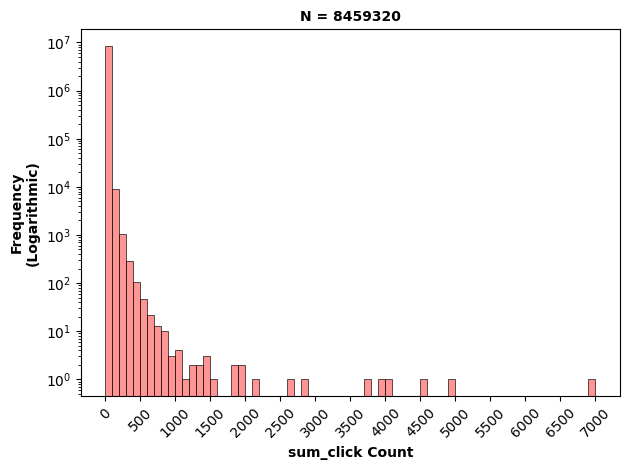

In [15]:
sns.histplot(
    dfs["studentvle"],
    x = "sum_click",
    color = "#ff7171",
    binwidth = 100,
    binrange = (
        0, 
        round(dfs["studentvle"]["sum_click"].max(), -3)
    )
)

plt.xlabel("sum_click Count", fontweight = "bold")
plt.xticks(np.arange(
    0, 
    round(dfs["studentvle"]["sum_click"].max(), -3) + 500, # round up to nearest 1000, add 500
    step = 500
    ),
    rotation = 45
)

plt.yscale("log")
plt.ylabel("Frequency\n(Logarithmic)", fontweight = "bold")

plt.title(f"N = {dfs["studentvle"].shape[0]}", fontweight = "bold", fontsize = 10)

plt.tight_layout()
plt.savefig("report_pdf/images/sum_click_hist.png")

Almost no click counts above ~1000

But what constitutes a "reasonable" amount of clicks?

Maybe some module materials involve user interactivity and so demand lots of clicks. 

We can note that click counts above ~1000 only have a frequency of ~5 at most. If these high click were due to online material that involved user interactivity, there would be much more than ~20-25 click counts measured above 1000, since entire cohorts of students are engaging with the materials, not just 1 or 2 people.

In [16]:
print(f"""
Click counts above 1000: {dfs["studentvle"][dfs["studentvle"]["sum_click"] > 1000].shape[0]}
      
Accounts for {dfs["studentvle"][dfs["studentvle"]["sum_click"] > 1000].shape[0] / (dfs["studentvle"].shape[0] - dfs["studentvle"][dfs["studentvle"]["sum_click"] > 1000].shape[0]) * 100:.5f}% of all click count events observed
""")


Click counts above 1000: 26
      
Accounts for 0.00031% of all click count events observed



Let's see which online materials these "high" click counts are referring to, along with which students are recording these click counts:

In [17]:
# get the "id_site" of the click counts > 2000
high_click_siteIDs = dfs["studentvle"][dfs["studentvle"]["sum_click"] > 1000]["id_site"].tolist()

# grab any rows from dfs["vle"] where the id_site is in the high_click_siteIDs list
sum_click_idsite = dfs["vle"][dfs["vle"]["id_site"].isin(high_click_siteIDs)].groupby("id_site").size().sort_values(ascending = False).reset_index()

sum_click_idsite

,id_site,0
0,526721,1
1,526853,1
2,546703,1
3,551035,1
4,551135,1
5,673519,1
6,716238,1
7,716434,1
8,716831,1
9,729798,1


In [18]:
sum_click_idstudent = dfs["studentvle"][dfs["studentvle"]["sum_click"] > 1000].groupby("id_student").size().sort_values(ascending = False).reset_index()

sum_click_idstudent

,id_student,0
0,582087,3
1,306202,2
2,285170,2
3,649840,2
4,204505,1
5,491011,1
6,368315,1
7,498031,1
8,497180,1
9,592214,1


In [19]:
sum_click_idsite.columns = ["id_site", "Frequency"]
sum_click_idstudent.columns = ["id_student", "Frequency"]

print(
    
    sum_click_idsite.to_latex(
        escape = True,
        index = False
    ),
    
    "\n\n\n\n",
    
    sum_click_idstudent.to_latex(
        escape = True,
        index = False, 
        column_format = "lc"
    ),
    
)

\begin{tabular}{rr}
\toprule
id\_site & Frequency \\
\midrule
526721 & 1 \\
526853 & 1 \\
546703 & 1 \\
551035 & 1 \\
551135 & 1 \\
673519 & 1 \\
716238 & 1 \\
716434 & 1 \\
716831 & 1 \\
729798 & 1 \\
729809 & 1 \\
729813 & 1 \\
729815 & 1 \\
729844 & 1 \\
773028 & 1 \\
790888 & 1 \\
814061 & 1 \\
832729 & 1 \\
909032 & 1 \\
909096 & 1 \\
909298 & 1 \\
909314 & 1 \\
909315 & 1 \\
913490 & 1 \\
913671 & 1 \\
\bottomrule
\end{tabular}
 



 \begin{tabular}{lc}
\toprule
id\_student & Frequency \\
\midrule
582087 & 3 \\
306202 & 2 \\
285170 & 2 \\
649840 & 2 \\
204505 & 1 \\
491011 & 1 \\
368315 & 1 \\
498031 & 1 \\
497180 & 1 \\
592214 & 1 \\
601224 & 1 \\
605868 & 1 \\
543643 & 1 \\
618606 & 1 \\
620337 & 1 \\
633902 & 1 \\
678395 & 1 \\
687378 & 1 \\
687563 & 1 \\
1894188 & 1 \\
2616950 & 1 \\
\bottomrule
\end{tabular}



There isn't any obvious pattern to these high click counts, in terms of id_site, nor is any student disproportionately responsible for them. Only 1 id_site has an associated week_from and week_to value. 

I feel these click counts are not legitimate user inputs, as it seems unlikely they should only occur 1-2 if the click count was typical of user input for that given material. If the high click count frequencies were much higher, I feel this would indicate genuine user behaviour.

As such, I am excluding click counts above 1000

In [20]:
studentvle_clickcount_over1000_count = dfs["studentvle"].drop(dfs["studentvle"][dfs["studentvle"]["sum_click"] > 1000].index).shape[0]

print(f"Reducing row count by {dfs["studentvle"].shape[0] - studentvle_clickcount_over1000_count}, from {dfs["studentvle"].shape[0]} rows to {studentvle_clickcount_over1000_count} rows")

Reducing row count by 26, from 8459320 rows to 8459294 rows


In [21]:
dfs["studentvle"] = dfs["studentvle"].drop(dfs["studentvle"][dfs["studentvle"]["sum_click"] > 1000].index).reset_index(drop = True)

dfs["studentvle"].describe(include = "all")

,id_student,id_site,code_presentation,code_module,date,sum_click
count,8.459294e+06,8.459294e+06,8459294,8459294,8.459294e+06,8.459294e+06
unique,NaN,NaN,4,7,NaN,NaN
top,NaN,NaN,2014J,FFF,NaN,NaN
freq,NaN,NaN,2802884,3248698,NaN,NaN
mean,7.332401e+05,7.351660e+05,NaN,NaN,9.393650e+01,4.674780e+00
std,5.846968e+05,1.307907e+05,NaN,NaN,7.598026e+01,9.839943e+00
min,6.516000e+03,5.267210e+05,NaN,NaN,-2.500000e+01,1.000000e+00
25%,5.057670e+05,6.735190e+05,NaN,NaN,2.400000e+01,1.000000e+00
50%,5.875500e+05,7.300350e+05,NaN,NaN,8.500000e+01,2.000000e+00
75%,6.459970e+05,8.327600e+05,NaN,NaN,1.550000e+02,4.000000e+00


##### Exploration and potential exclusion of "?" values

When inspecting the data, I found some columns which should be int64-type were instead object-type. This was due to the presence of question marks, presumably indicating that the value is unknown. These rows need to be removed and these columns converted to int64

 - studentassessment
   - score 
 - studentinfo
   - imd_band
 - studentregistration
   - date_registered AND date_unregistered

In [22]:
dfs["assessments"][dfs["assessments"]["date"] == "?"]

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,?,100.0
11,AAA,2014J,1763,Exam,?,100.0
23,BBB,2013B,14990,Exam,?,100.0
35,BBB,2013J,15002,Exam,?,100.0
47,BBB,2014B,15014,Exam,?,100.0
53,BBB,2014J,15025,Exam,?,100.0
62,CCC,2014B,24290,Exam,?,100.0
63,CCC,2014B,40087,Exam,?,100.0
72,CCC,2014J,24299,Exam,?,100.0
73,CCC,2014J,40088,Exam,?,100.0


Can't exclude as these are still real assessments

Moving on to studentassessment["score"]

In [23]:
dfs["studentassessment"][dfs["studentassessment"]["score"] == "?"]

,id_assessment,id_student,date_submitted,is_banked,score
215,1752,721259,22,0,?
937,1754,260355,127,0,?
2364,1760,2606802,180,0,?
3358,14984,186780,77,0,?
3914,14984,531205,26,0,?
...,...,...,...,...,...
148929,34903,582670,241,0,?
159251,37415,610738,87,0,?
166390,37427,631786,221,0,?
169725,37435,648110,62,0,?


The score is unknown but they have a submission date. 

We aren't inherently interested in the date of submission. Score is important for predicting grades, so removing these rows is reasonable - we can't predict scores from data points with no score, even if we were interested in the relationship between submission date and scores.

In [24]:
dfs["studentassessment"].drop(dfs["studentassessment"][dfs["studentassessment"]["score"] == "?"].index)

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78
1,1752,28400,22,0,70
2,1752,31604,17,0,72
3,1752,32885,26,0,69
4,1752,38053,19,0,79
...,...,...,...,...,...
173907,37443,527538,227,0,60
173908,37443,534672,229,0,100
173909,37443,546286,215,0,80
173910,37443,546724,230,0,100


In [25]:
studentassessment_score_qmark_count = dfs["studentassessment"].drop(dfs["studentassessment"][dfs["studentassessment"]["score"] == "?"].index).shape[0]

print(f"Reducing row count by {dfs["studentassessment"].shape[0] - studentassessment_score_qmark_count}, from {dfs["studentvle"].shape[0]} rows to {studentassessment_score_qmark_count} rows")

Reducing row count by 173, from 8459294 rows to 173739 rows


In [26]:
dfs["studentassessment"] = dfs["studentassessment"].drop(dfs["studentassessment"][dfs["studentassessment"]["score"] == "?"].index).reset_index(drop = True)

dfs["studentassessment"].describe(include = "all")

,id_assessment,id_student,date_submitted,is_banked,score
count,173739.000000,1.737390e+05,173739.000000,173739.000000,173739
unique,NaN,NaN,NaN,NaN,101
top,NaN,NaN,NaN,NaN,100
freq,NaN,NaN,NaN,NaN,18813
mean,26555.615826,7.052474e+05,116.020226,0.010982,NaN
std,8829.999907,5.524822e+05,71.479612,0.104218,NaN
min,1752.000000,6.516000e+03,-11.000000,0.000000,NaN
25%,15022.000000,5.044660e+05,51.000000,0.000000,NaN
50%,25359.000000,5.852220e+05,116.000000,0.000000,NaN
75%,34883.000000,6.345000e+05,173.000000,0.000000,NaN


As for studentregistration[["date_registration", "date_unregistration"]]

In [27]:
dfs["studentregistration"][(dfs["studentregistration"]["date_registration"] == "?") & (dfs["studentregistration"]["date_unregistration"] == "?")]

,code_module,code_presentation,id_student,date_registration,date_unregistration
2344,BBB,2013B,630346,?,?
12893,CCC,2014J,1777834,?,?
14392,DDD,2013B,2707979,?,?
14393,DDD,2013B,2710343,?,?
17559,DDD,2014B,2710343,?,?
23796,FFF,2013B,2102658,?,?


In [28]:
studentregistration_both_qmark_count = dfs["studentregistration"].drop(dfs["studentregistration"][(dfs["studentregistration"]["date_registration"] == "?") & (dfs["studentregistration"]["date_unregistration"] == "?")].index).shape[0]

print(f"Reducing row count by {dfs["studentregistration"].shape[0] - studentregistration_both_qmark_count}, from {dfs["studentregistration"].shape[0]} rows to {studentregistration_both_qmark_count} rows")

Reducing row count by 6, from 32593 rows to 32587 rows


In [29]:
dfs["studentregistration"] = dfs["studentregistration"].drop(dfs["studentregistration"][(dfs["studentregistration"]["date_registration"] == "?") & (dfs["studentregistration"]["date_unregistration"] == "?")].index).reset_index(drop = True)

Need to now ensure all columns have the correct data types

In [30]:
for df_name, df in dfs.items():
    
    # ensure all columns that contain just numeric values are converted, ignore other columns
    dfs[df_name] = dfs[df_name].apply(pd.to_numeric, errors = "ignore")
    
    print(f"\n--- {df_name} ---\n\n{dfs[df_name].describe(include = "all")}\n\n")


--- assessments ---

       code_module code_presentation  id_assessment assessment_type date      weight
count          206               206     206.000000             206  206  206.000000
unique           7                 4            NaN               3   75         NaN
top            FFF             2014J            NaN             TMA  222         NaN
freq            52                57            NaN             106   15         NaN
mean           NaN               NaN   26473.975728             NaN  NaN   20.873786
std            NaN               NaN   10098.625521             NaN  NaN   30.384224
min            NaN               NaN    1752.000000             NaN  NaN    0.000000
25%            NaN               NaN   15023.250000             NaN  NaN    0.000000
50%            NaN               NaN   25364.500000             NaN  NaN   12.500000
75%            NaN               NaN   34891.750000             NaN  NaN   24.250000
max            NaN               NaN   4008

C:\Users\Charlie\AppData\Local\Temp\ipykernel_12824\3280549736.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  dfs[df_name] = dfs[df_name].apply(pd.to_numeric, errors = "ignore")
C:\Users\Charlie\AppData\Local\Temp\ipykernel_12824\3280549736.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  dfs[df_name] = dfs[df_name].apply(pd.to_numeric, errors = "ignore")
C:\Users\Charlie\AppData\Local\Temp\ipykernel_12824\3280549736.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  dfs[df_name] = dfs[df_name].apply(pd.to_numeric, errors = "ignore")
C:\Users\Charlie\AppData\Local\Temp\ipykernel_12824\3280549736.py:4: FutureWarning: errors='ignore' 


--- studentvle ---

          id_student       id_site code_presentation code_module          date     sum_click
count   8.459294e+06  8.459294e+06           8459294     8459294  8.459294e+06  8.459294e+06
unique           NaN           NaN                 4           7           NaN           NaN
top              NaN           NaN             2014J         FFF           NaN           NaN
freq             NaN           NaN           2802884     3248698           NaN           NaN
mean    7.332401e+05  7.351660e+05               NaN         NaN  9.393650e+01  4.674780e+00
std     5.846968e+05  1.307907e+05               NaN         NaN  7.598026e+01  9.839943e+00
min     6.516000e+03  5.267210e+05               NaN         NaN -2.500000e+01  1.000000e+00
25%     5.057670e+05  6.735190e+05               NaN         NaN  2.400000e+01  1.000000e+00
50%     5.875500e+05  7.300350e+05               NaN         NaN  8.500000e+01  2.000000e+00
75%     6.459970e+05  8.327600e+05               

C:\Users\Charlie\AppData\Local\Temp\ipykernel_12824\3280549736.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  dfs[df_name] = dfs[df_name].apply(pd.to_numeric, errors = "ignore")


Looks accurate

Next, we need to look into why the minimum date for studentassessment["date_submitted"] is -11

In [31]:
dfs["studentassessment"][dfs["studentassessment"]["date_submitted"] < 0].sort_values("date_submitted", ascending = True)

,id_assessment,id_student,date_submitted,is_banked,score
28754,15008,559381,-11,0,63
76152,25348,2472145,-10,0,85
15847,14996,610700,-9,0,75
110994,34866,529561,-8,0,99
111344,34866,557840,-8,0,88
...,...,...,...,...,...
172353,37440,631446,-1,1,100
172544,37441,624767,-1,1,100
172554,37441,631446,-1,1,100
173066,37442,624767,-1,1,100


In [32]:
dfs["studentassessment"][(dfs["studentassessment"]["date_submitted"] < 0) & (dfs["studentassessment"]["is_banked"] == 1)].describe()

,id_assessment,id_student,date_submitted,is_banked,score
count,1908.000000,1.908000e+03,1908.0,1908.0,1908.000000
mean,25457.124214,7.160595e+05,-1.0,1.0,74.345912
std,8414.358644,6.482137e+05,0.0,0.0,17.432884
min,1758.000000,8.462000e+03,-1.0,1.0,0.000000
25%,15016.000000,4.156980e+05,-1.0,1.0,64.000000
50%,25360.500000,5.263030e+05,-1.0,1.0,76.000000
75%,34878.250000,6.058590e+05,-1.0,1.0,87.000000
max,37442.000000,2.694680e+06,-1.0,1.0,100.000000


all the assessments with a date_submitted less than 0 and is_banked = 1 have a date_submitted value of -1. My guess is this implies these are due to some automated system involved in carrying over assessments from previous module presentation periods. 

As for those dates < -1, let's see which assessments they refer to

In [33]:
dfs["assessments"][dfs["assessments"]["id_assessment"].isin(set(dfs["studentassessment"][dfs["studentassessment"]["date_submitted"] < -1]["id_assessment"].tolist()))]

,code_module,code_presentation,id_assessment,assessment_type,date,weight
17,BBB,2013B,14984,TMA,19,5.0
29,BBB,2013J,14996,TMA,19,5.0
41,BBB,2014B,15008,TMA,12,5.0
48,BBB,2014J,15020,TMA,19,0.0
81,DDD,2013B,25334,TMA,25,7.5
88,DDD,2013J,25348,TMA,25,10.0
95,DDD,2014B,25355,TMA,25,10.0
124,FFF,2013B,34865,CMA,222,0.0
125,FFF,2013B,34866,CMA,222,0.0
131,FFF,2013B,34860,TMA,19,12.5


None of these are final exams, but most are weighted

Since it is not clear why these assessments have some submission dates before the module presentations begin, and it could be reasonable for a module to have an assessment before module presentation (e.g. pre-semester assessment, the assessment is used to assess prior knowledge, etc.), I am going to not exclude them.

Lastly, we need to look into dfs["studentinfo"]["studied_credits"]

The longest course at the OU is 3 years (full time), equating to 360 credits. However, someone might have studied more than one degree - let's check

In [34]:
dfs["studentinfo"][dfs["studentinfo"]["studied_credits"] > 360]

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
57,AAA,2013J,155550,M,London Region,A Level or Equivalent,0-10%,35-55,0,420,N,Pass
865,BBB,2013B,230348,F,East Anglian Region,A Level or Equivalent,0-10%,0-35,2,585,N,Withdrawn
2778,BBB,2013J,363151,M,North Western Region,Lower Than A Level,10-20,35-55,0,655,Y,Withdrawn
3210,BBB,2013J,528642,F,Wales,Lower Than A Level,40-50%,0-35,0,390,N,Withdrawn
8734,CCC,2014B,153687,F,South Region,A Level or Equivalent,60-70%,35-55,0,400,N,Withdrawn
10378,CCC,2014B,1474869,F,South Region,A Level or Equivalent,90-100%,35-55,0,630,Y,Pass
11315,CCC,2014J,556788,M,North Region,Lower Than A Level,?,35-55,1,480,N,Withdrawn
16424,DDD,2014B,244438,M,North Western Region,A Level or Equivalent,10-20,0-35,1,540,N,Withdrawn
17854,DDD,2014J,447393,F,Scotland,HE Qualification,90-100%,0-35,2,370,N,Withdrawn
22976,FFF,2013B,520153,F,West Midlands Region,Lower Than A Level,40-50%,0-35,0,400,N,Withdrawn


In [35]:
dfs["studentregistration"][dfs["studentregistration"]["id_student"].isin(set(dfs["studentinfo"][dfs["studentinfo"]["studied_credits"] > 360]["id_student"].tolist()))]

,code_module,code_presentation,id_student,date_registration,date_unregistration
57,AAA,2013J,155550,-16,?
865,BBB,2013B,230348,-121,-68
2777,BBB,2013J,363151,-81,-71
3156,BBB,2013J,520153,-191,-110
3209,BBB,2013J,528642,-110,-93
8733,CCC,2014B,153687,-37,-30
10377,CCC,2014B,1474869,-5,?
11314,CCC,2014J,556788,-38,-14
13745,DDD,2013B,528642,-119,23
16420,DDD,2014B,244438,-34,0


It doesn't seem to be the case that these students with more than 360 credits have taken more than one course, since they only have one recorded registration each.

Again, to avoid assuming too much about how the courses work, I am not going to remove these "high" studied_credit rows from studentinfo

##### Weighted Scores

At present, "score" is currently unweighted. We need to provide a weighting to the scores on each assessment if we want to consider the score a student got on an entire module. This is because a student's module score is the sum of their weighted scores on each assessment for that module, not the average of their raw scores on each assessment. 

First, we can merge "studentassessment" and the "weight" column from "assessments" using a left join on the id_assessment variable

In [36]:
dfs["studentassessment"] = pd.merge(
    dfs["studentassessment"], 
    dfs["assessments"][["weight", "id_assessment"]], 
    on = "id_assessment", 
    how = "left"
)

dfs["studentassessment"]

,id_assessment,id_student,date_submitted,is_banked,score,weight
0,1752,11391,18,0,78,10.0
1,1752,28400,22,0,70,10.0
2,1752,31604,17,0,72,10.0
3,1752,32885,26,0,69,10.0
4,1752,38053,19,0,79,10.0
...,...,...,...,...,...,...
173734,37443,527538,227,0,60,0.0
173735,37443,534672,229,0,100,0.0
173736,37443,546286,215,0,80,0.0
173737,37443,546724,230,0,100,0.0


Then we need to create a new column "weighted_score". Firstly, converting "weight" to a decimal and then multiplying it with the "score" column

In [37]:
dfs["studentassessment"]["weighted_score"] = dfs["studentassessment"]["score"] * (dfs["studentassessment"]["weight"] / 100)

dfs["studentassessment"]

,id_assessment,id_student,date_submitted,is_banked,score,weight,weighted_score
0,1752,11391,18,0,78,10.0,7.8
1,1752,28400,22,0,70,10.0,7.0
2,1752,31604,17,0,72,10.0,7.2
3,1752,32885,26,0,69,10.0,6.9
4,1752,38053,19,0,79,10.0,7.9
...,...,...,...,...,...,...,...
173734,37443,527538,227,0,60,0.0,0.0
173735,37443,534672,229,0,100,0.0,0.0
173736,37443,546286,215,0,80,0.0,0.0
173737,37443,546724,230,0,100,0.0,0.0


## Exploratory Data Analysis

##### Dataset information

In [38]:
dfs["studentinfo"]["id_student"]

0          11391
1          28400
2          30268
3          31604
4          32885
          ...   
32588    2640965
32589    2645731
32590    2648187
32591    2679821
32592    2684003
Name: id_student, Length: 32593, dtype: int64

In [39]:
# Number of students
no_of_students = len(set(dfs["studentinfo"]["id_student"].tolist()))

# Number of modules
no_of_modules = len(set(dfs["courses"]["code_module"].tolist()))

# Number of assessments
no_of_assessments = len(set(dfs["assessments"]["id_assessment"].tolist()))

# Types of assessments
types_of_assessments = set(dfs["assessments"]["assessment_type"].tolist())

##### Histograms of student demographics (incl. Age!)

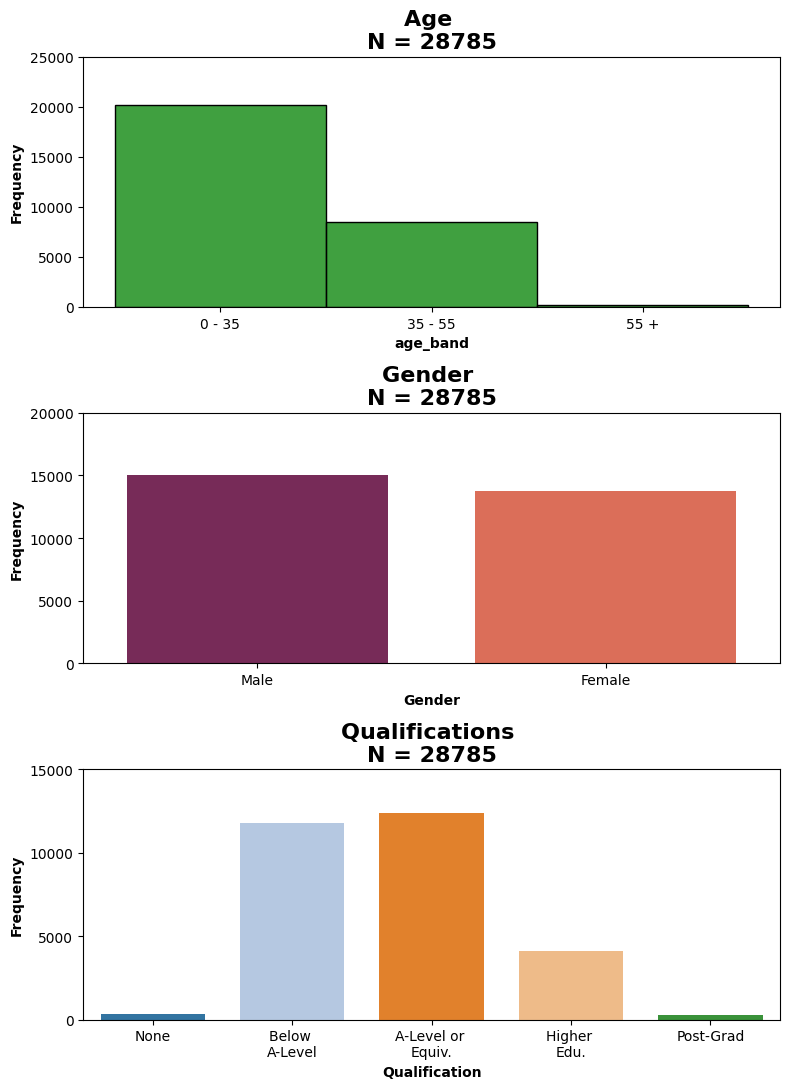

In [40]:
fig, ax = plt.subplots(3, 1, figsize = (8, 11))

# Age

dfs["studentinfo"]["age_band"] = dfs["studentinfo"]["age_band"].astype(
    pd.CategoricalDtype(
        categories = ["0-35", "35-55", "55<="],
        ordered = True
    )
)

sns.histplot(
    dfs["studentinfo"].drop_duplicates("id_student"),
    x = "age_band",
    ax = ax[0],
    color = "green"
)

ax[0].set_xlabel("age_band", fontweight = "bold")
ax[0].set_xticks(
    ticks = range(3),
    labels = ["0 - 35", "35 - 55", "55 +"]
)

ax[0].set_ylabel("Frequency", fontweight = "bold")
ax[0].set_ylim(top = 25000)

ax[0].set_title(f"Age \nN = {no_of_students}", fontweight = "bold", fontsize = 16)

# Gender

sns.countplot(
    dfs["studentinfo"].drop_duplicates("id_student"),
    x = "gender",
    order = dfs["studentinfo"]["gender"].value_counts().index,
    palette = "rocket",
    hue = "gender",
    legend = False,
    width = 0.75,
    ax = ax[1]
)

ax[1].set_xlabel("Gender", fontweight = "bold")
ax[1].set_xticks(
    ticks = range(2),
    labels = ["Male", "Female"]
)

ax[1].set_ylabel("Frequency", fontweight = "bold")
ax[1].set_yticks(np.arange(0, 20001, 5000))

ax[1].set_title(f"Gender \nN = {no_of_students}", fontweight = "bold", fontsize = 16)

# Qualifications

dfs["studentinfo"]["highest_education"] = dfs["studentinfo"]["highest_education"].astype(
    pd.CategoricalDtype(
        categories = ["No Formal quals", "Lower Than A Level", "A Level or Equivalent", "HE Qualification", "Post Graduate Qualification"],
        ordered = True
    )
)

sns.countplot(
    dfs["studentinfo"].drop_duplicates("id_student"),
    x = "highest_education",
    #order = dfs["studentinfo"]["highest_education"].value_counts().index,
    palette = "tab20",
    hue = "highest_education",
    legend = False,
    width = 0.75,
    ax = ax[2]
)

ax[2].set_xlabel("Qualification", fontweight = "bold")
ax[2].set_xticks(
    ticks = range(5),
    labels = ["None", "Below \nA-Level", "A-Level or \nEquiv.", "Higher \nEdu.", "Post-Grad"]
)

ax[2].set_ylabel("Frequency", fontweight = "bold")
ax[2].set_yticks(np.arange(0, 15001, 5000))

ax[2].set_title(f"Qualifications \nN = {no_of_students}", fontweight = "bold", fontsize = 16)

plt.tight_layout()
plt.savefig("report_pdf/images/demodist_pt1.png")
plt.show()

C:\Users\Charlie\AppData\Local\Temp\ipykernel_12824\2347319452.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfs["studentinfo"].drop_duplicates("id_student")[dfs["studentinfo"]["imd_band"] != "?"],


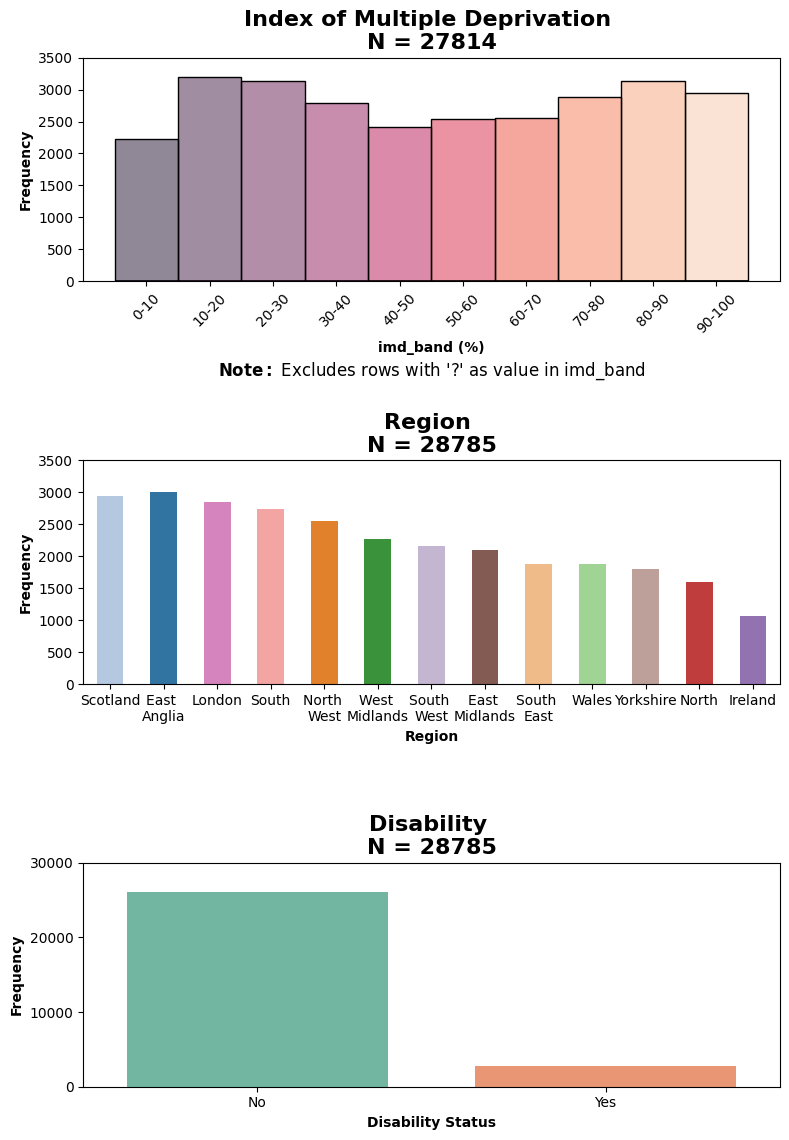

In [41]:
fig, ax = plt.subplots(3, 1, figsize = (8, 11.5))

# IMD

sns.histplot(
    dfs["studentinfo"].drop_duplicates("id_student")[dfs["studentinfo"]["imd_band"] != "?"],
    x = "imd_band",
    palette = "rocket",
    hue = "imd_band",
    legend = False,
    ax = ax[0]
)

ax[0].set_xlabel("imd_band (%)", fontweight = "bold")
ax[0].set_xticks(
    ticks = range(10),
    labels = ["0-10", "10-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-80", "80-90", "90-100"],
    rotation = 45
)

ax[0].set_ylabel("Frequency", fontweight = "bold")
ax[0].set_yticks(np.arange(0, 3501, 500))

ax[0].set_title(f"Index of Multiple Deprivation \nN = {len(set(dfs["studentinfo"][dfs["studentinfo"]["imd_band"] != "?"]["id_student"].tolist()))}", fontweight = "bold", fontsize = 16)

ax[0].text(
    0.5, -0.4, 
    r"$\bf{Note:}$" + " Excludes rows with '?' as value in imd_band", 
    transform = ax[0].transAxes, 
    ha = "center", va = "center", fontsize = 12
)

# Regions

sns.countplot(
    dfs["studentinfo"].drop_duplicates("id_student"),
    x = "region",
    order = dfs["studentinfo"]["region"].value_counts().index,
    palette = "tab20",
    hue = "region",
    legend = False,
    width = 0.5,
    ax = ax[1]
)

ax[1].set_xlabel("Region", fontweight = "bold")
ax[1].set_xticks(
    ticks = range(13),
    labels = ["Scotland", "East \nAnglia", "London", "South", "North \nWest", "West \nMidlands", "South \nWest", "East \nMidlands", "South \nEast", "Wales", "Yorkshire", "North", "Ireland"]
)

ax[1].set_ylabel("Frequency", fontweight = "bold")
ax[1].set_ylim(top = 3500)

ax[1].set_title(f"\nRegion \nN = {no_of_students}", fontweight = "bold", fontsize = 16)

# Disability

sns.countplot(
    dfs["studentinfo"].drop_duplicates("id_student"),
    x = "disability",
    #order = dfs["studentinfo"]["highest_education"].value_counts().index,
    palette = "Set2",
    hue = "disability",
    legend = False,
    width = 0.75,
    ax = ax[2]
)

ax[2].set_xlabel("Disability Status", fontweight = "bold")
ax[2].set_xticks(
    ticks = range(2),
    labels = ["No", "Yes"]
)

ax[2].set_ylabel("Frequency", fontweight = "bold")
ax[2].set_yticks(np.arange(0, 30001, 10000))

ax[2].set_title(f"Disability \nN = {no_of_students}", fontweight = "bold", fontsize = 16)

plt.tight_layout(h_pad = -0.5)
plt.savefig("report_pdf/images/demodist_pt2.png")
plt.show()

In [42]:
# required EDA findings

# top 5 modules with the highest average score

# top 5 modules with the lowest average score

# top 5 modules with the most number of fails

# weekly activity patterns of the students' interaction with the VLE

##### top 5 modules chosen by students

In [43]:
# need to use id_student and code_module as unique ID now since we want to account for students who have taken more than 1 module (e.g. due to switching modules)
print(f"{dfs["studentinfo"].drop_duplicates(["id_student", "code_module", "code_presentation"], keep = "first").shape[0]}\n")


top5_modules_chosen = dfs["studentinfo"].drop_duplicates(["id_student", "code_module"], keep = "first")["code_module"].value_counts().head(5).reset_index()

top5_modules_chosen.columns = ["Module Code", "Frequency"]

top5_modules_chosen["Frequency"] = top5_modules_chosen["Frequency"].apply(lambda x: f"{x:,}")

print(top5_modules_chosen.to_latex(
    escape = False,  
    index = False,
    column_format = "p{5cm}c", 
    float_format = "{:.1f}".format
))

32593

\begin{tabular}{p{5cm}c}
\toprule
Module Code & Frequency \\
\midrule
BBB & 7,692 \\
FFF & 7,397 \\
DDD & 5,848 \\
CCC & 4,251 \\
EEE & 2,859 \\
\bottomrule
\end{tabular}



##### top 5 modules with the highest average score

In [44]:
module_eda = pd.merge(
    dfs["studentassessment"], 
    dfs["assessments"][["code_module", "code_presentation", "assessment_type", "id_assessment"]], 
    on = "id_assessment", 
    how = "left"
)

In [45]:
# explanation of code logic

### 1. filter "assessment_type" != "Exams"
### 2. group by "code_module", "code_presentation" and "id_assessment"
### 3. find mean average "weighted_score" for each assessment
### 4. group by "code_module", "code_presentation"
### 5. sum average "weighted_scores" for each assessment in each "code_module"-"code_presentation" grouping
### 6. group by "code_module"
### 7. find mean of these summed average "weighted_scores"
### 8. sort in descending order
### result: each module sorted by average "weighted_score" (for non-Exam assessments)

module_average_score_TMACMA = module_eda[module_eda["assessment_type"] != "Exam"].groupby(["code_module", "code_presentation", "id_assessment"])["weighted_score"].mean().groupby(["code_module", "code_presentation"]).sum().groupby("code_module").mean().reset_index().sort_values("weighted_score", ascending = False)

module_average_score_TMACMA.columns = ["Module Code", "Average Score (Weighted)"]

print(module_average_score_TMACMA.to_latex(
    escape = True,  
    index = False,
    column_format = "p{5cm}c"
))


\begin{tabular}{p{5cm}c}
\toprule
Module Code & Average Score (Weighted) \\
\midrule
EEE & 80.003304 \\
FFF & 74.375273 \\
CCC & 73.698638 \\
BBB & 71.476875 \\
AAA & 68.979322 \\
DDD & 68.694923 \\
GGG & 0.000000 \\
\bottomrule
\end{tabular}



In [46]:
# explanation of code logic

### 1. filter to just "Exams"
### 2. group by "code_module", "code_presentation" and "id_assessment"
### 3. find mean average "weighted_score" for each grouping
### 4. group by "code_module", "code_presentation"
### 5. sum average weighted_scores
### 6. group by "code_module"
### 7. find mean of these summed average weighted_scores
### 8. sort in descending order
### result: each module sorted by average "weighted_score" (for Exam assessments only)

module_average_score_exams = module_eda[module_eda["assessment_type"] == "Exam"].groupby(["code_module", "code_presentation", "id_assessment"])["weighted_score"].mean().groupby(["code_module", "code_presentation"]).sum().groupby("code_module").mean().reset_index().sort_values("weighted_score", ascending = False)

module_average_score_exams.columns = ["Module Code", "Average Score (Weighted)"]

print(module_average_score_exams.to_latex(
    escape = True,  
    index = False,
    column_format = "p{5cm}c"
))



\begin{tabular}{p{5cm}c}
\toprule
Module Code & Average Score (Weighted) \\
\midrule
CCC & 69.102569 \\
DDD & 63.444204 \\
\bottomrule
\end{tabular}



In [47]:
print(len(dfs["studentinfo"][["code_module", "final_result"]]), "\n")

module_most_fails = dfs["studentinfo"][["code_module", "final_result"]][dfs["studentinfo"][["code_module", "final_result"]]["final_result"] == "Fail"].groupby("code_module").count().reset_index().sort_values("final_result", ascending = False).head(5)

module_most_fails.columns = ["Module Code", "Number of Fails"]

print(module_most_fails.to_latex(
    escape = True,  
    index = False,
    column_format = "p{5cm}c"
))


32593 

\begin{tabular}{p{5cm}c}
\toprule
Module Code & Number of Fails \\
\midrule
BBB & 1767 \\
FFF & 1711 \\
DDD & 1412 \\
CCC & 781 \\
GGG & 728 \\
\bottomrule
\end{tabular}



##### Weekly activity patterns of the students' interaction with the VLE

Since we don't have actual dates to work with, just number of days relative to module start date, we have to define a week relative to the module start date (which is likely a Monday anyway, but we can't be sure)

We need to create a "week_since_start" column so we know which week each sum_click event belongs to. We can achieve this by floor dividing each "date" value by 7. As such, week 0 corresponds to dates 0-6, week 1 = dates 7-13, week -1 = -1 to -6 etc.

We can find the average sum_click count per week to get an overall picture of student interaction with the VLE, for all modules. We can also group by module to see if the interaction patterns vary

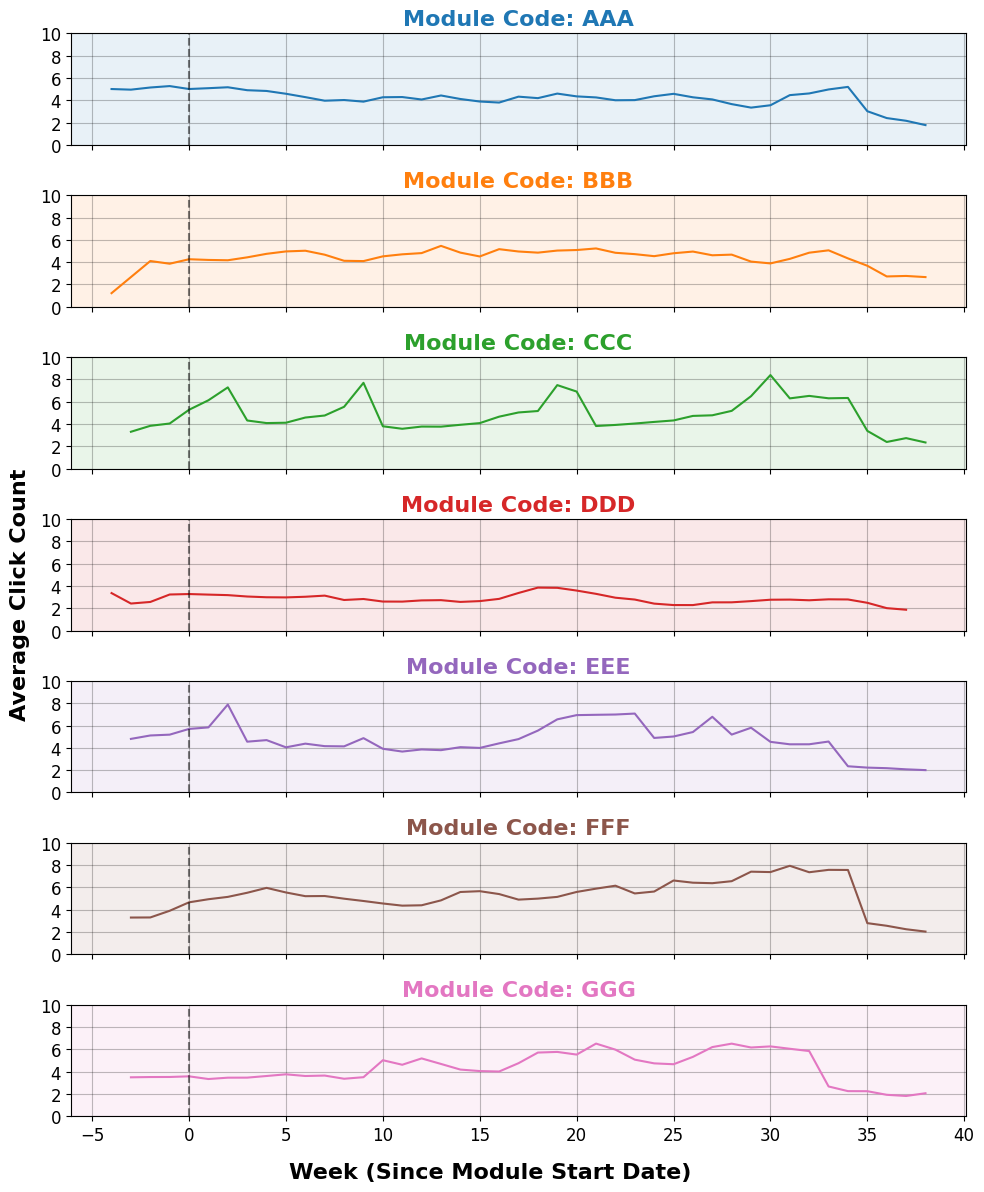

In [48]:
dfs["studentvle"]["week_since_start"] = dfs["studentvle"]["date"] // 7

weekly_vle_interaction = dfs["studentvle"].groupby(["week_since_start", "code_module"])["sum_click"].mean().reset_index()

weekly_vle_interaction.columns = ["Week (Since Module Start Date)", "Module Code", "Average Click Count"]

fig, axes = plt.subplots(7, 1, figsize = (10, 12), sharex = True, sharey = True)

colours = plt.cm.tab10.colors
panel_colours = [mcolors.to_rgba(c, alpha = 0.1) for c in colours]

for i, module in enumerate(sorted(weekly_vle_interaction["Module Code"].unique())):
    sns.lineplot(
        weekly_vle_interaction[weekly_vle_interaction["Module Code"] == module],
        x = "Week (Since Module Start Date)",
        y = "Average Click Count",
        color = colours[i],
        ax = axes[i]
    )
    
    axes[i].grid(color = "black", alpha = 0.25)
    axes[i].axvline(x = 0, color = "black", alpha = 0.5, linestyle = "--")
    
    axes[i].set_xlabel("")
    axes[i].set_xticks(np.arange(-5, 45, 5))
    axes[i].set_xlim(axes[0].get_xlim())
    
    axes[i].set_ylabel("")
    axes[i].set_yticks(np.arange(0, 11, 2))
    axes[i].set_ylim(axes[0].get_ylim())
    
    axes[i].tick_params(axis = "both", labelsize = 12)
    
    axes[i].set_title(f"Module Code: {module}", fontweight = "bold", fontsize = 16) 
    axes[i].title.set_color(colours[i])
    
    axes[i].set_facecolor(panel_colours[i])

fig.supxlabel("Week (Since Module Start Date)", fontweight = "bold", fontsize = 16)

fig.supylabel("Average Click Count", fontweight = "bold", fontsize = 16)

plt.tight_layout()
plt.savefig("report_pdf/images/weekly_vle.png")

Peaks in Module CCC might be due to online assessments

In [49]:
module_CCC_CMA_dates = pd.to_numeric(
    dfs["assessments"][(dfs["assessments"]["code_module"] == "CCC") & (dfs["assessments"]["assessment_type"] == "CMA")]["date"]
).to_numpy()

module_CCC_CMA_dates // 7

array([ 2,  9, 19, 29,  2,  9, 20, 30])

Seems to be so!

Also, module DDD has consistent low engagement

##### Average Score Over Time

In [50]:
score_over_time = pd.merge(
    module_eda,
    dfs["assessments"][["id_assessment", "date"]],
    on = "id_assessment",
    how = "left"
)

score_over_time_data = score_over_time[["code_presentation", "code_module", "date", "score"]].groupby(["code_presentation", "code_module", "date"]).mean().reset_index()

score_over_time_data = score_over_time_data[pd.to_numeric(score_over_time_data["date"], errors = "coerce").notnull()]
score_over_time_data["date"] = score_over_time_data["date"].astype("float64")

score_over_time_data.sort_values(["code_presentation", "code_module"])

,code_presentation,code_module,date,score
0,2013B,BBB,124.0,79.509404
1,2013B,BBB,159.0,80.079602
2,2013B,BBB,187.0,79.031231
3,2013B,BBB,19.0,71.215293
4,2013B,BBB,47.0,70.105263
...,...,...,...,...
132,2014J,FFF,94.0,74.279685
133,2014J,GGG,124.0,68.912963
134,2014J,GGG,173.0,67.370000
135,2014J,GGG,229.0,85.869676


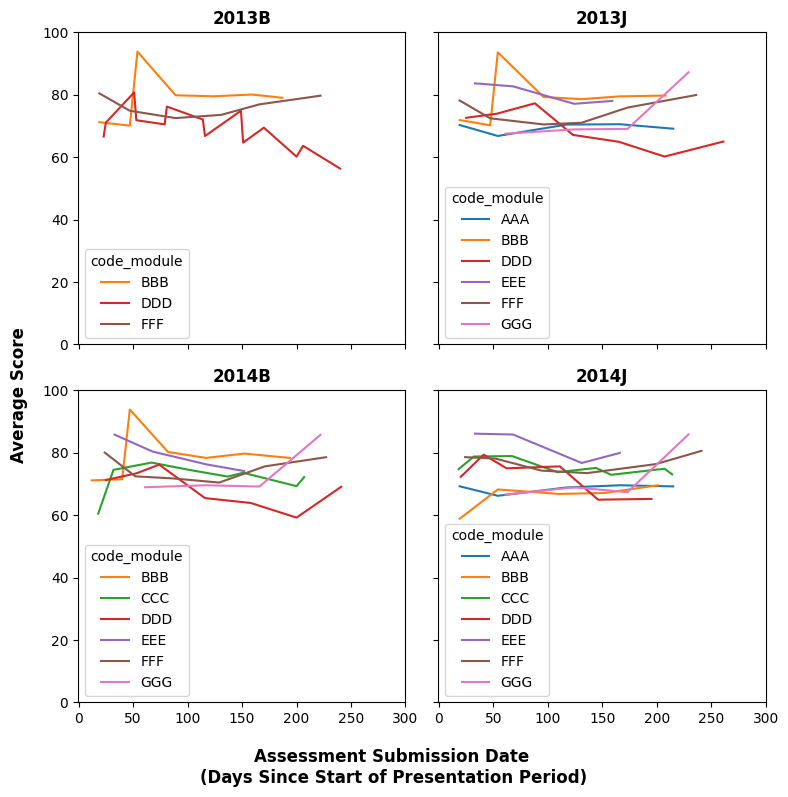

In [51]:
fig, axes = plt.subplots(2, 2, figsize = (8, 8), sharex = True, sharey = True)

score_over_time_colour_dict = {
    "AAA" : colours[0],
    "BBB" : colours[1],
    "CCC" : colours[2],
    "DDD" : colours[3],
    "EEE" : colours[4],
    "FFF" : colours[5],
    "GGG" : colours[6]
}

for presentation_period, ax in zip(score_over_time_data["code_presentation"].unique(), axes.ravel()):
    sns.lineplot(
        score_over_time_data[score_over_time_data["code_presentation"] == presentation_period],
        x = "date",
        y = "score",
        hue = "code_module",
        palette = score_over_time_colour_dict,
        ax = ax
    )
    
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(presentation_period, fontweight = "bold")

plt.xticks(np.arange(0, 301, 50))
fig.supxlabel("Assessment Submission Date \n(Days Since Start of Presentation Period)", fontweight = "bold")

plt.yticks(np.arange(0, 101, 20))
fig.supylabel("Average Score", fontweight = "bold")

plt.tight_layout()
plt.savefig("report_pdf/images/avr_score_time.png")

##### Click-Score Correlation

Firstly, before correlating click counts with average scores, we need to filter out students who not completed many assessments (e.g. only 1). To do this, I'm going to exclude students who have completed less assessments than the module with the lowest assessment count. This way, we can be sure that these excluded students have at least not completed an entire module. Some students who remain may also have not completed an entire module, but they still will have completed more assessments that someone who only took the module with the fewest assessments.

In [52]:
no_assessments_per_student = dfs["studentassessment"][["id_student", "id_assessment"]].groupby("id_student").count().reset_index().sort_values("id_assessment", ascending = False)

no_assessments_per_student = no_assessments_per_student.rename(columns = {"id_assessment" : "count"})

min_no_of_assessments = float(dfs["assessments"][["code_presentation", "code_module", "id_assessment"]].groupby(["code_presentation", "code_module"]).count().min())

studentIDs_with_enough_assessments = np.array(no_assessments_per_student[no_assessments_per_student["count"] > min_no_of_assessments]["id_student"])


C:\Users\Charlie\AppData\Local\Temp\ipykernel_12824\1981296209.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  min_no_of_assessments = float(dfs["assessments"][["code_presentation", "code_module", "id_assessment"]].groupby(["code_presentation", "code_module"]).count().min())


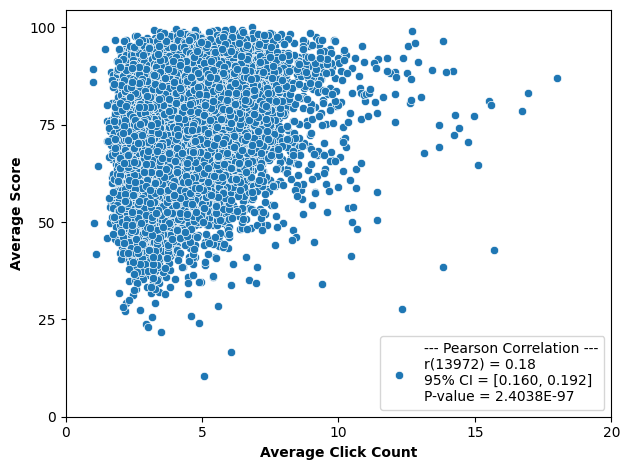

In [53]:
clickscore_corr_clicks = dfs["studentvle"][["id_student", "sum_click"]].groupby("id_student").mean().reset_index()

clickscore_corr_scores = dfs["studentassessment"][["id_student", "score"]].groupby("id_student").mean().reset_index()

clickscore_corr_data = pd.merge(
    clickscore_corr_clicks, 
    clickscore_corr_scores, 
    on = "id_student", 
    how = "inner"
)

clickscore_corr_data = clickscore_corr_data[clickscore_corr_data["id_student"].isin(studentIDs_with_enough_assessments)]

clickscore_corr = sp.stats.pearsonr(
    clickscore_corr_data["sum_click"], 
    clickscore_corr_data["score"]
)

sns.scatterplot(
    clickscore_corr_data, 
    x = "sum_click",
    y = "score", 
    label = f"--- Pearson Correlation ---\nr({len(clickscore_corr_data) - 2}) = {float(clickscore_corr[0]):.2f} \n95% CI = [{clickscore_corr.confidence_interval(confidence_level = 0.95)[0]:.3f}, {clickscore_corr.confidence_interval(confidence_level = 0.95)[1]:.3f}]\nP-value = {float(clickscore_corr[1]):.4E}"
)

plt.xlabel("Average Click Count", fontweight = "bold")
plt.xticks(np.arange(0, 21, 5))

plt.ylabel("Average Score", fontweight = "bold")
plt.yticks(np.arange(0, 101, 25))

plt.tight_layout()
plt.savefig("report_pdf/images/click_score_corr.png")

The correlation between students' average click count and their average assessment score is statistically significant but practically negligible

Number of unique dates interacting with VLE and Score - correlation

In [54]:
dfs["studentvle"][["id_student", "date"]].drop_duplicates(["id_student", "date"], keep = "first").groupby(["id_student"]).count().reset_index()

,id_student,date
0,6516,159
1,8462,56
2,11391,40
3,23629,16
4,23698,70
...,...,...
26069,2698251,77
26070,2698257,69
26071,2698535,131
26072,2698577,37


In [55]:
dfs["studentassessment"][["id_student", "score"]].groupby("id_student").mean().reset_index()

vledays_score_data = pd.merge(
    dfs["studentassessment"][["id_student", "score"]].groupby("id_student").mean().reset_index(),
    dfs["studentvle"][["id_student", "date"]].drop_duplicates(["id_student", "date"], keep = "first").groupby(["id_student"]).count().reset_index(),
    on = "id_student",
    how = "left"
)

vledays_score_data = vledays_score_data[pd.to_numeric(vledays_score_data["date"], errors = "coerce").notnull()]
vledays_score_data = vledays_score_data.rename(columns = {"date" : "num_days_interact"})

vledays_score_data = vledays_score_data[vledays_score_data["id_student"].isin(studentIDs_with_enough_assessments)]

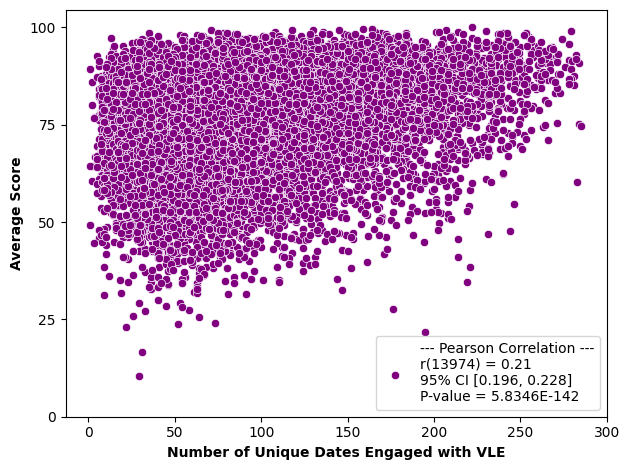

In [56]:

vledays_score_corr = sp.stats.pearsonr(
    vledays_score_data["num_days_interact"], 
    vledays_score_data["score"]
)

sns.scatterplot(
    vledays_score_data,
    x = "num_days_interact",
    y = "score", 
    color = "purple",
    label = f"--- Pearson Correlation ---\nr({len(vledays_score_data - 2)}) = {float(vledays_score_corr[0]):.2f} \n95% CI [{vledays_score_corr.confidence_interval(confidence_level = 0.95)[0]:.3f}, {vledays_score_corr.confidence_interval(confidence_level = 0.95)[1]:.3f}] \nP-value = {float(vledays_score_corr[1]):.4E}"
)

plt.xlabel("Number of Unique Dates Engaged with VLE", fontweight = "bold")
plt.xticks(np.arange(0, 301, 50))

plt.ylabel("Average Score", fontweight = "bold")
plt.yticks(np.arange(0, 101, 25))

plt.title("")

plt.tight_layout()
plt.savefig("report_pdf/images/vledays_score_corr.png")

A statistically significant weak correlation

In [57]:
vle_improve_score_data = pd.merge(
    vledays_score_data,
    clickscore_corr_clicks,
    on = "id_student",
    how = "left"
)

vle_improve_score_data

,id_student,score,num_days_interact,sum_click
0,8462,87.000000,56.0,2.285714
1,23698,74.444444,70.0,3.654618
2,23798,93.909091,77.0,2.500000
3,24186,62.500000,23.0,3.755102
4,24213,76.285714,118.0,3.151899
...,...,...,...,...
13969,2697885,74.916667,108.0,3.112853
13970,2697921,74.375000,112.0,5.536585
13971,2698125,78.666667,42.0,5.975962
13972,2698251,58.142857,77.0,3.102669


In [58]:
pca = PCA(n_components = 1).fit(vle_improve_score_data[["num_days_interact", "sum_click"]])

vle_engagement = pca.transform(vle_improve_score_data[["num_days_interact", "sum_click"]]).flatten()

vle_engagement_data = pd.DataFrame({
    "id_student" : vle_improve_score_data["id_student"],
    "score" : vle_improve_score_data["score"],
    "vle_engagement" : vle_engagement
})

scaler = MinMaxScaler(feature_range = (0, 100))

vle_engagement_data[["vle_engagement"]] = scaler.fit_transform(vle_engagement_data[["vle_engagement"]])

vle_engagement_data["vle_level"] = vle_engagement_data["vle_engagement"].apply(lambda x: "Low" if x < 50 else "High")

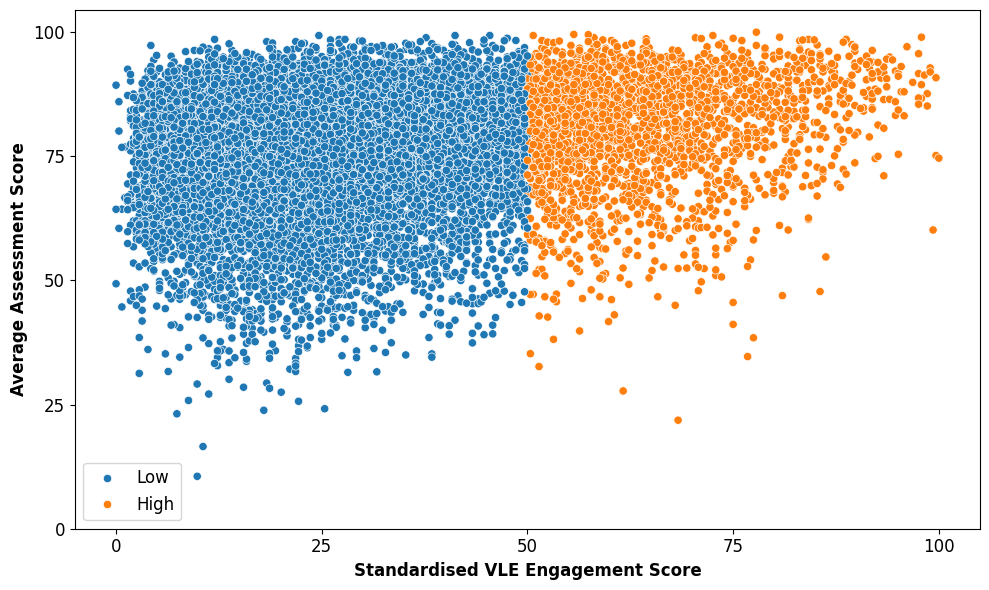

In [59]:

plt.figure(figsize = (10, 6))

sns.scatterplot(
    vle_engagement_data, 
    x = "vle_engagement",
    y = "score", 
    hue = "vle_level"
)

plt.xlabel("Standardised VLE Engagement Score", fontweight = "bold", fontsize = 12)
plt.xticks(np.arange(0, 101, 25), fontsize = 12)

plt.ylabel("Average Assessment Score", fontweight = "bold", fontsize = 12)
plt.yticks(np.arange(0, 101, 25), fontsize = 12)

plt.legend(prop = {"size" : 12})

plt.tight_layout()
plt.savefig("report_pdf/images/vle_score_scatter.png")

In [60]:
low_VLE_sample = vle_engagement_data[vle_engagement_data["vle_level"] == "Low"]
high_VLE_sample = vle_engagement_data[vle_engagement_data["vle_level"] == "High"]

multiheader = pd.MultiIndex(
    levels = [["", "Score", "VLE Engagement"], ["VLE Engagement \nLevel", "N", "Mean", "Stdev", "Min", "Max"]],
    codes = [[0,0,1,1,1,1,2,2,2,2],
             [0,1,2,3,4,5,2,3,4,5]]
)

VLE_samples_summary_stats = pd.DataFrame(
    [
        [
            "Low", 
            low_VLE_sample.shape[0], 
            low_VLE_sample["score"].mean(), 
            low_VLE_sample["score"].std(), 
            low_VLE_sample["score"].min(),
            low_VLE_sample["score"].max(), 
            low_VLE_sample["vle_engagement"].mean(), 
            low_VLE_sample["vle_engagement"].std(), 
            low_VLE_sample["vle_engagement"].min(),
            low_VLE_sample["vle_engagement"].max()
        ],
        [
            "High", 
            high_VLE_sample.shape[0], 
            high_VLE_sample["score"].mean(), 
            high_VLE_sample["score"].std(), 
            high_VLE_sample["score"].min(),
            high_VLE_sample["score"].max(), 
            high_VLE_sample["vle_engagement"].mean(), 
            high_VLE_sample["vle_engagement"].std(), 
            high_VLE_sample["vle_engagement"].min(),
            high_VLE_sample["vle_engagement"].max()
        ]
    ], 
    columns = multiheader)

print(
    VLE_samples_summary_stats.to_latex(
        escape = True,  
        index = False,
        column_format = "lccccccccc",
        float_format = "{:.2f}".format
    )
)

\begin{tabular}{lccccccccc}
\toprule
\multicolumn{2}{r}{} & \multicolumn{4}{r}{Score} & \multicolumn{4}{r}{VLE Engagement} \\
VLE Engagement 
Level & N & Mean & Stdev & Min & Max & Mean & Stdev & Min & Max \\
\midrule
Low & 11330 & 75.64 & 12.11 & 10.56 & 99.33 & 24.68 & 12.47 & 0.00 & 50.00 \\
High & 2644 & 81.01 & 10.78 & 21.86 & 100.00 & 63.97 & 11.09 & 50.00 & 100.00 \\
\bottomrule
\end{tabular}



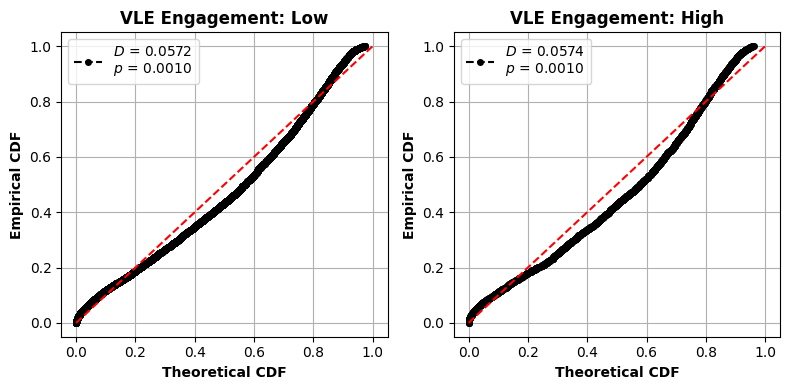

In [61]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))

for i, level in enumerate(vle_engagement_data["vle_level"].unique()):

    dataframe_sorted = np.sort(vle_engagement_data["score"][(vle_engagement_data["vle_level"] == level)])
    
    sample_cdf = np.arange(1, len(dataframe_sorted) + 1) / len(dataframe_sorted)
    
    theoretical_cdf = sp.stats.norm.cdf(
        dataframe_sorted, 
        loc = np.mean(dataframe_sorted), 
        scale = np.std(dataframe_sorted)
    )
    
    lilliefors_stat, lilliefors_pvalue = lilliefors(sample_cdf, dist = "norm")
       
    ax[i].plot(
        theoretical_cdf, 
        sample_cdf, 
        marker = "o", 
        linestyle = "--", 
        color = "black", 
        markersize = 4
    )
    
    ax[i].plot([0, 1], [0, 1], color = "red", linestyle = "--")
    
    ax[i].set_xlabel("Theoretical CDF", fontweight = "bold", fontsize = 10)
    
    ax[i].set_ylabel("Empirical CDF", fontweight = "bold", fontsize = 10)
    
    ax[i].xaxis.set_tick_params(labelsize = 10)
    ax[i].yaxis.set_tick_params(labelsize = 10)
    
    ax[i].legend(
        [f"$D$ = {lilliefors_stat:.4f} \n$p$ = {lilliefors_pvalue:.4f}"], 
        loc = "upper left",
        fontsize = 10
    ) 
    
    ax[i].grid()
        
    ax[i].set_title(f"VLE Engagement: {level}", fontweight = "bold", fontsize = 12)

plt.tight_layout()
plt.savefig("report_pdf/images/ppplot.png")

Significantly different, which isn't ideal. However, our sample sizes are quite large, so violating normality is not necessarily a reason to abandon using a Welch's t-test.

In [62]:
print(
    f"Low: {vle_engagement_data[vle_engagement_data["vle_level"] == "Low"].shape[0]}\nHigh: {vle_engagement_data[vle_engagement_data["vle_level"] == "High"].shape[0]}"
)

Low: 11330
High: 2644


Whilst there is a large class imbalance, the smallest class is still consisting of over 2,500 independent data points. As such, a t-test is still appropriate to use

In [63]:
vle_engagement_data

,id_student,score,vle_engagement,vle_level
0,8462,87.000000,19.366325,Low
1,23698,74.444444,24.297558,Low
2,23798,93.909091,26.760309,Low
3,24186,62.500000,7.750020,Low
4,24213,76.285714,41.196547,Low
...,...,...,...,...
13969,2697885,74.916667,37.675700,Low
13970,2697921,74.375000,39.087790,Low
13971,2698125,78.666667,14.442973,Low
13972,2698251,58.142857,26.761248,Low


T-statistic: 22.506134753212443, P-value: 1.7389020061880545e-106, DoF 13972


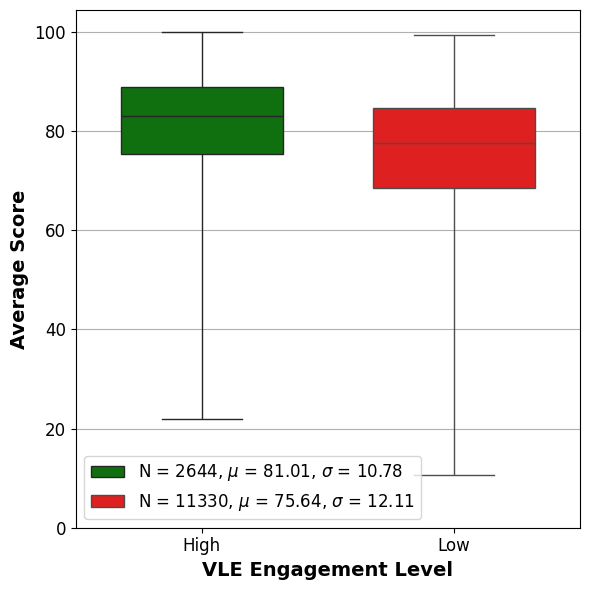

In [64]:
t_statistic, p_value = sp.stats.ttest_ind( 
    vle_engagement_data["score"][vle_engagement_data["vle_level"] == "High"], 
    vle_engagement_data["score"][vle_engagement_data["vle_level"] == "Low"],
    equal_var = False,
    alternative = "greater"
)

print(f"T-statistic: {t_statistic}, P-value: {p_value}, DoF {vle_engagement_data["score"][vle_engagement_data["vle_level"] == "Low"].shape[0] + vle_engagement_data["score"][vle_engagement_data["vle_level"] == "High"].shape[0] - 2}")

plt.figure(figsize = (6, 6))

sns.boxplot(
    vle_engagement_data[vle_engagement_data["vle_level"] == "High"],
    y = "score",
    x = "vle_level",
    color = "green",
    fill = True, 
    whis = (0, 100),
    width = 0.8,
    gap = 0.2,
    label = f"N = {vle_engagement_data["score"][vle_engagement_data["vle_level"] == "High"].shape[0]}, " + "$\\mu$ = " + f"{np.mean(vle_engagement_data["score"][vle_engagement_data["vle_level"] == "High"]):.2f}" + ", $\\sigma$ = " + f"{np.std(vle_engagement_data["score"][vle_engagement_data["vle_level"] == "High"]):.2f}"
)

sns.boxplot(
    vle_engagement_data[vle_engagement_data["vle_level"] == "Low"],
    y = "score",
    x = "vle_level",
    color = "red",
    fill = True, 
    whis = (0, 100),
    width = 0.8,
    gap = 0.2,
    label = f"N = {vle_engagement_data["score"][vle_engagement_data["vle_level"] == "Low"].shape[0]}, " + "$\\mu$ = " + f"{np.mean(vle_engagement_data["score"][vle_engagement_data["vle_level"] == "Low"]):.2f}" + ", $\\sigma$ = " + f"{np.std(vle_engagement_data["score"][vle_engagement_data["vle_level"] == "Low"]):.2f}"
)

plt.grid(axis = "y")

plt.xlabel("VLE Engagement Level", fontweight = "bold", fontsize = 14)
plt.xticks(fontsize = 12)

plt.ylabel("Average Score", fontweight = "bold", fontsize = 14)
plt.yticks(np.arange(0, 101, 20), fontsize = 12)

plt.legend(loc = "lower left", fontsize = 12)
plt.tight_layout()
plt.savefig("report_pdf/images/ttest.png")

Whilst "high" vle engagement has significantly higher average scores, the difference is quite small. 

### Can we predict students' grades?

"Withdrawn" records should be excluded as this does not refer to a grade.

Since some students have retaken modules, it might seem reasonable to exclude duplicate student IDs. However, keeping those duplicates gives us more information about each feature's contribution to predicting final_result. As such, we will keep duplicate student IDs

In [65]:
dfs["studentinfo"][dfs["studentinfo"]["final_result"] == "Withdrawn"].shape[0]

10156

In [66]:
predict_grades = dfs["studentinfo"][dfs["studentinfo"]["final_result"] != "Withdrawn"][["id_student", "gender", "region", "highest_education", "imd_band", "age_band", "disability", "final_result"]]

predict_grades

,id_student,gender,region,highest_education,imd_band,age_band,disability,final_result
0,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,N,Pass
1,28400,F,Scotland,HE Qualification,20-30%,35-55,N,Pass
3,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,N,Pass
4,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,N,Pass
5,38053,M,Wales,A Level or Equivalent,80-90%,35-55,N,Pass
...,...,...,...,...,...,...,...,...
32587,2620947,F,Scotland,A Level or Equivalent,80-90%,0-35,Y,Distinction
32588,2640965,F,Wales,Lower Than A Level,10-20,0-35,N,Fail
32589,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,N,Distinction
32590,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,Y,Pass


In [67]:
predict_grades_sum_click = pd.merge(
    predict_grades,
    clickscore_corr_clicks,
    on = "id_student",
    how = "left"
)

predict_grades_sum_click

,id_student,gender,region,highest_education,imd_band,age_band,disability,final_result,sum_click
0,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,N,Pass,5.592814
1,28400,F,Scotland,HE Qualification,20-30%,35-55,N,Pass,4.019608
2,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,N,Pass,3.952381
3,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,N,Pass,3.324759
4,38053,M,Wales,A Level or Equivalent,80-90%,35-55,N,Pass,4.289474
...,...,...,...,...,...,...,...,...,...
22432,2620947,F,Scotland,A Level or Equivalent,80-90%,0-35,Y,Distinction,3.838710
22433,2640965,F,Wales,Lower Than A Level,10-20,0-35,N,Fail,2.411765
22434,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,N,Distinction,5.222222
22435,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,Y,Pass,4.105263


In [68]:
predict_grades_data = pd.merge(
    predict_grades_sum_click,
    dfs["studentvle"][["id_student", "date"]].drop_duplicates(["id_student", "date"], keep = "first").groupby(["id_student"]).count().reset_index(),
    on = "id_student",
    how = "left"
)

predict_grades_data = predict_grades_data.rename(columns = {"date" : "num_days_interact"})

Need to exclude "?" values from imd_band

In [69]:
predict_grades_data = predict_grades_data[predict_grades_data["imd_band"] != "?"]

In [70]:
predict_grades_data = pd.merge(
    predict_grades_data,
    dfs["studentinfo"][["id_student", "num_of_prev_attempts"]],
    on = "id_student",
    how = "left"
)

Many features, including the DV, are categorical. As such, these need to be recoded. Some columns are ordinal so this need to be taken into account when recoding their levels.

In [71]:
for col in predict_grades_data.columns[1:]:

    print(f"{col}: {predict_grades_data[col].dtype}")

    if predict_grades_data[col].dtype != "float64":
        print(
            np.sort(predict_grades_data[col].unique()),
            "\n"
        )
    if predict_grades_data[col].dtype == "float64":
        print(
            f"Range: ({predict_grades_data[col].min()}, {predict_grades_data[col].max()})\n"
        )

gender: object
['F' 'M'] 

region: object
['East Anglian Region' 'East Midlands Region' 'Ireland' 'London Region'
 'North Region' 'North Western Region' 'Scotland' 'South East Region'
 'South Region' 'South West Region' 'Wales' 'West Midlands Region'
 'Yorkshire Region'] 

highest_education: category
['A Level or Equivalent' 'HE Qualification' 'Lower Than A Level'
 'No Formal quals' 'Post Graduate Qualification'] 

imd_band: object
['0-10%' '10-20' '20-30%' '30-40%' '40-50%' '50-60%' '60-70%' '70-80%'
 '80-90%' '90-100%'] 

age_band: category
['0-35' '35-55' '55<='] 

disability: object
['N' 'Y'] 

final_result: object
['Distinction' 'Fail' 'Pass'] 

sum_click: float64
Range: (1.0, 31.541176470588237)

num_days_interact: float64
Range: (1.0, 286.0)

num_of_prev_attempts: int64
[0 1 2 3 4 5 6] 



Need to note down which levels are being used as the reference categories for each nominal variable. Pandas automatically uses the first level, sorted in alphabetical order.

However, for region I am deciding to use London as the reference category as it seems more reasonable to me to contrast each UK region with the capital. Much regional politics/economics in the UK revolves around comparisons to London, so it may make interpretation more meaningful in a political/economic sense.

As for gender and disability, the choice is arbitrary since these are binary (in this data set!) variables anyway.

In [72]:
predict_grades_data["region"] = pd.Categorical(
    predict_grades_data["region"],
    categories = [
        "London Region",
        "East Anglian Region",
        "East Midlands Region",
        "Ireland",
        "North Region",
        "North Western Region",
        "Scotland",
        "South East Region",
        "South Region",
        "South West Region",
        "Wales",
        "West Midlands Region",
        "Yorkshire Region"
    ],
    ordered = True
)

print("""--- Reference categories ---
      
gender: F (Female)       
region: London Region
disability: N (No)
""")

--- Reference categories ---
      
gender: F (Female)       
region: London Region
disability: N (No)



In [73]:
predict_grades_data["num_of_prev_attempts"] = pd.Categorical(
    predict_grades_data["num_of_prev_attempts"],
    categories = [
        0, 1, 2, 3, 4, 5, 6
    ],
    ordered = True
)

Need to one-hot encode our nominal variables

In [74]:
predict_grades_data_onehot = pd.get_dummies(predict_grades_data, columns = ["gender", "region", "disability",], drop_first = True, dtype = "int")

predict_grades_data_onehot.columns = predict_grades_data_onehot .columns.str.replace(" ", "_")

predict_grades_data_onehot

,id_student,highest_education,imd_band,age_band,final_result,sum_click,num_days_interact,num_of_prev_attempts,gender_M,region_East_Anglian_Region,...,region_North_Region,region_North_Western_Region,region_Scotland,region_South_East_Region,region_South_Region,region_South_West_Region,region_Wales,region_West_Midlands_Region,region_Yorkshire_Region,disability_Y
0,11391,HE Qualification,90-100%,55<=,Pass,5.592814,40.0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,28400,HE Qualification,20-30%,35-55,Pass,4.019608,80.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,31604,A Level or Equivalent,50-60%,35-55,Pass,3.952381,123.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,32885,Lower Than A Level,50-60%,0-35,Pass,3.324759,70.0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,38053,A Level or Equivalent,80-90%,35-55,Pass,4.289474,143.0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25713,2620947,A Level or Equivalent,80-90%,0-35,Distinction,3.838710,35.0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
25714,2640965,Lower Than A Level,10-20,0-35,Fail,2.411765,5.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
25715,2645731,Lower Than A Level,40-50%,35-55,Distinction,5.222222,45.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
25716,2648187,A Level or Equivalent,20-30%,0-35,Pass,4.105263,24.0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


Specify correct level order of ordinal variables

In [75]:
predict_grades_data_onehot["imd_band"] = predict_grades_data_onehot["imd_band"].replace({
    "0-10%" : 0,
    "10-20" : 1/9,
    "20-30%" : 2/9,
    "30-40%" : 3/9,
    "40-50%" : 4/9,
    "50-60%" : 5/9,
    "60-70%" : 6/9,
    "70-80%" : 7/9,
    "80-90%" : 8/9,
    "90-100%" : 1
})

predict_grades_data_onehot["highest_education"] = predict_grades_data_onehot["highest_education"].replace({
    "No Formal quals" : 0,
    "Lower Than A Level" : 1/4,
    "A Level or Equivalent" : 2/4,
    "HE Qualification" : 3/4,
    "Post Graduate Qualification" : 1
})

predict_grades_data_onehot["age_band"] = predict_grades_data_onehot["age_band"].replace({
    "0-35" : 0,
    "35-55" : 1/2,
    "55<=" : 1
})

predict_grades_data_onehot["final_result"] = predict_grades_data_onehot["final_result"].replace({
    "Fail" : 0,
    "Pass" : 1,
    "Distinction" : 1
})

C:\Users\Charlie\AppData\Local\Temp\ipykernel_12824\1267092278.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predict_grades_data_onehot["imd_band"] = predict_grades_data_onehot["imd_band"].replace({
C:\Users\Charlie\AppData\Local\Temp\ipykernel_12824\1267092278.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predict_grades_data_onehot["highest_education"] = predict_grades_data_onehot["highest_education"].replace({
C:\Users\Charlie\AppData\Local\Temp\ipykernel_12824\1267092278.py:14: FutureWarning: The behavior of Series

In [76]:
cols = ["id_student", "final_result"]
predict_grades_data_final = predict_grades_data_onehot[cols + [c for c in predict_grades_data_onehot.columns if c not in cols]]

for col in predict_grades_data_final.columns:
    predict_grades_data_final[col] = pd.to_numeric(predict_grades_data_final[col])

In [77]:
predict_grades_data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25718 entries, 0 to 25717
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id_student                   25718 non-null  int64  
 1   final_result                 25718 non-null  int64  
 2   highest_education            25718 non-null  float64
 3   imd_band                     25718 non-null  float64
 4   age_band                     25718 non-null  float64
 5   sum_click                    25368 non-null  float64
 6   num_days_interact            25368 non-null  float64
 7   num_of_prev_attempts         25718 non-null  int64  
 8   gender_M                     25718 non-null  int64  
 9   region_East_Anglian_Region   25718 non-null  int64  
 10  region_East_Midlands_Region  25718 non-null  int64  
 11  region_Ireland               25718 non-null  int64  
 12  region_North_Region          25718 non-null  int64  
 13  region_North_Wes

sum_click and num_days_interact have nulls. This is due to students who did not recode any interaction with VLE materials. Imputing with 0 is appropriate as this reflects their actual level of engagement - of course, we don't know why they did not engage but that isn't within the scope of this report

In [78]:
predict_grades_data_final = predict_grades_data_final.fillna(0)

Check correlations between predictors

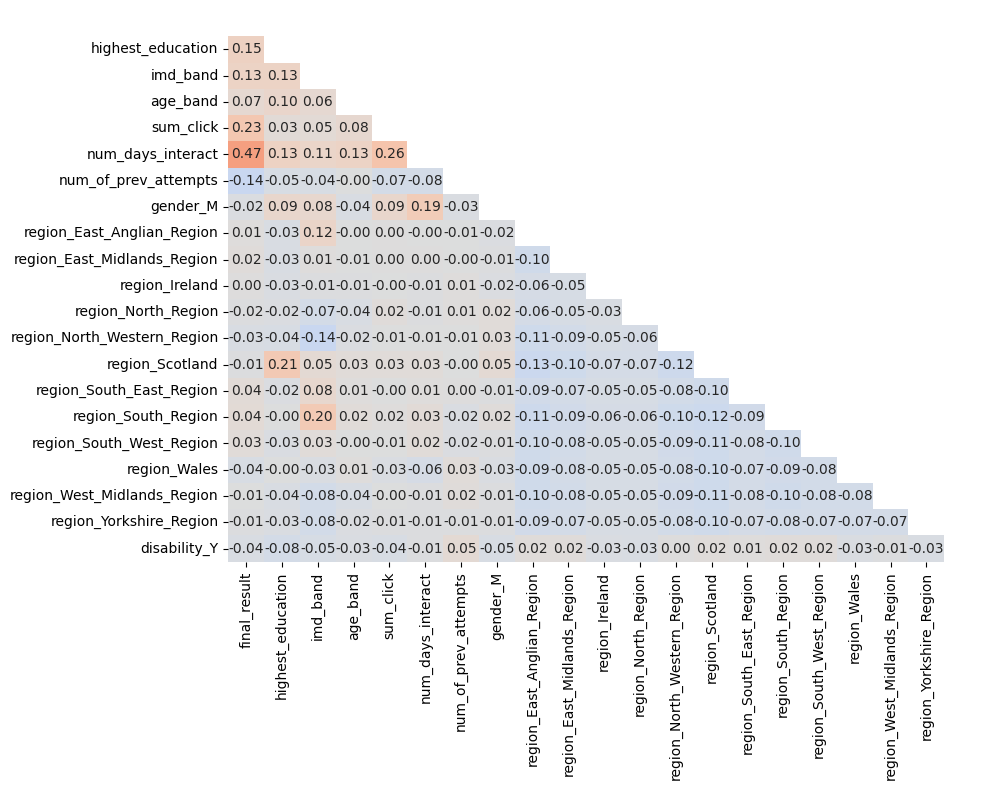

In [79]:
log_regression_corr_matrix = predict_grades_data_final.drop(["id_student"], axis=1).corr(method = "pearson")

plt.figure(figsize = (10, 8)) 

ax = sns.heatmap(
    log_regression_corr_matrix , 
    annot = True, 
    annot_kws={"fontsize" : 10},
    fmt = ".2f", 
    cmap = "coolwarm", 
    center = 0,
    vmin = -1,
    vmax = 1,
    cbar = False,
    mask = np.triu(np.ones_like(log_regression_corr_matrix , dtype = bool))
)

ax.set_xticks(ax.get_xticks()[:-1]) 
ax.set_yticks(ax.get_yticks()[1:])

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.tight_layout()
plt.savefig("report_pdf/images/regression_corr_matrix.png")

No predictors share any meaningful correlations. Highest pearson coefficient is 0.273, between num_days_interact and sum_click (our VLE engagement measures). Scotland correlates most with highest_education (0.198) and South Region correlates most with imd_band (0.204).

In [80]:
predict_grades_data_final

,id_student,final_result,highest_education,imd_band,age_band,sum_click,num_days_interact,num_of_prev_attempts,gender_M,region_East_Anglian_Region,...,region_North_Region,region_North_Western_Region,region_Scotland,region_South_East_Region,region_South_Region,region_South_West_Region,region_Wales,region_West_Midlands_Region,region_Yorkshire_Region,disability_Y
0,11391,1,0.75,1.000000,1.0,5.592814,40.0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,28400,1,0.75,0.222222,0.5,4.019608,80.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,31604,1,0.50,0.555556,0.5,3.952381,123.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,32885,1,0.25,0.555556,0.0,3.324759,70.0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,38053,1,0.50,0.888889,0.5,4.289474,143.0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25713,2620947,1,0.50,0.888889,0.0,3.838710,35.0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
25714,2640965,0,0.25,0.111111,0.0,2.411765,5.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
25715,2645731,1,0.25,0.444444,0.5,5.222222,45.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
25716,2648187,1,0.50,0.222222,0.0,4.105263,24.0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [81]:
print(f"""--- Sample Sizes of Each final_result Level ---
Fail: {predict_grades_data_final[predict_grades_data_final["final_result"] == 0].shape[0]} ({predict_grades_data_final[predict_grades_data_final["final_result"] == 0].shape[0] / predict_grades_data_final.shape[0] * 100:.2f}%)
Pass: {predict_grades_data_final[predict_grades_data_final["final_result"] == 1].shape[0]} ({predict_grades_data_final[predict_grades_data_final["final_result"] == 1].shape[0] / predict_grades_data_final.shape[0] * 100:.2f}%)

""")

--- Sample Sizes of Each final_result Level ---
Fail: 8302 (32.28%)
Pass: 17416 (67.72%)




We can note that we have a class imbalance, where passes constitute a super-majority of the data. Since our sample sizes for each final_result level is quite large (> 5000), I'm deciding to use under-sampling on the majority class in order to address the class imbalance. I will draw a random sample from the "passes" rows of equal size to the number of "fail" rows

In [82]:
random.seed(123)

predict_grades_data_final_balanced = pd.concat([
    predict_grades_data_final[predict_grades_data_final["final_result"] == 0],
    predict_grades_data_final[predict_grades_data_final["final_result"] == 1].sample(len(predict_grades_data_final[predict_grades_data_final["final_result"] == 0]))
], axis = 0)

In [83]:
predict_grades_data_final_balanced

,id_student,final_result,highest_education,imd_band,age_band,sum_click,num_days_interact,num_of_prev_attempts,gender_M,region_East_Anglian_Region,...,region_North_Region,region_North_Western_Region,region_Scotland,region_South_East_Region,region_South_Region,region_South_West_Region,region_Wales,region_West_Midlands_Region,region_Yorkshire_Region,disability_Y
14,74372,0,0.50,0.111111,0.5,1.757576,14.0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
40,146188,0,0.50,0.222222,0.0,3.532544,32.0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
41,147756,0,0.25,0.666667,0.0,3.395257,127.0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
42,147756,0,0.25,0.666667,0.0,3.395257,127.0,1,1,0,...,1,0,0,0,0,0,0,0,0,0
52,175991,0,0.50,0.888889,0.0,2.936170,17.0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21843,281134,1,0.50,0.222222,0.0,4.721779,162.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1136,513315,1,0.25,0.111111,0.0,3.255020,82.0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3825,531755,1,0.75,0.888889,0.0,2.987654,21.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
8692,596846,1,0.50,0.555556,0.0,3.541892,130.0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [84]:
func = ""
for col in predict_grades_data_final_balanced.columns[2:]:
    func = f"{func} + {col}"
    
predict_grades_model = sm.Logit.from_formula(
    f"final_result ~ {func}",
    data = predict_grades_data_final_balanced
)

predict_grades_model_fit = predict_grades_model.fit()

Optimization terminated successfully.
         Current function value: 0.501934
         Iterations 6


In [85]:
func

' + highest_education + imd_band + age_band + sum_click + num_days_interact + num_of_prev_attempts + gender_M + region_East_Anglian_Region + region_East_Midlands_Region + region_Ireland + region_North_Region + region_North_Western_Region + region_Scotland + region_South_East_Region + region_South_Region + region_South_West_Region + region_Wales + region_West_Midlands_Region + region_Yorkshire_Region + disability_Y'

In [86]:
predict_grades_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           final_result   No. Observations:                16604
Model:                          Logit   Df Residuals:                    16583
Method:                           MLE   Df Model:                           20
Date:                Sat, 04 Jan 2025   Pseudo R-squ.:                  0.2759
Time:                        12:49:05   Log-Likelihood:                -8334.1
converged:                       True   LL-Null:                       -11509.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -2.7590      0.097    -28.520      0.000      -2.949      -2.569
highest_education               1.3921      0.110     12.644      0.000       1.176       1.608
imd_band                        0.5393      0.066      8.210      0.000       0.411       0.668
age_band                        0.0324      0.084      0.387      0.699      -0.132       0.197
sum_click                       0.1728      0.012     14.233      0.000       0.149       0.197
num_days_interact               0.0251      0.000     53.686      0.000       0.024       0.026
num_of_prev_attempts           -0.5658      0.043    -13.163      0.000      -0.650      -0.482
gender_M                       -0.8248      0.041    -20.277      0.000      -0.905      -0.745
region_East_Anglian_Region      0.0712      0.085      0.834      0.404      -0.096       0.238
region_East_Midlands_Region     0.2477      0.094      2.635      0.008       0.063       0.432
region_Ireland                  0.2743      0.123      2.226      0.026       0.033       0.516
region_North_Region             0.1324      0.120      1.104      0.269      -0.103       0.367
region_North_Western_Region    -0.0983      0.088     -1.113      0.266      -0.271       0.075
region_Scotland                -0.2617      0.083     -3.158      0.002      -0.424      -0.099
region_South_East_Region        0.4134      0.097      4.246      0.000       0.223       0.604
region_South_Region             0.2239      0.090      2.500      0.012       0.048       0.399
region_South_West_Region        0.3046      0.093      3.290      0.001       0.123       0.486
region_Wales                   -0.0164      0.093     -0.177      0.860      -0.198       0.165
region_West_Midlands_Region     0.0773      0.091      0.847      0.397      -0.102       0.256
region_Yorkshire_Region         0.1064      0.096      1.111      0.267      -0.081       0.294
disability_Y                   -0.2018      0.067     -3.031      0.002      -0.332      -0.071
===============================================================================================
"""

In [87]:
intercept = predict_grades_model_fit.summary2().tables[1]["Coef."].iloc[0]

# using the logistic function to convert to a probability
baseline_pass_prob = round(1 / (1 + np.exp(-intercept)) * 100 , 2)

print(f"Baseline probability of passing: {baseline_pass_prob}%")

Baseline probability of passing: 5.96%


In [88]:
print(predict_grades_model_fit.summary2().as_latex())

\begin{table}
\caption{Results: Logit}
\label{}
\begin{center}
\begin{tabular}{llll}
\hline
Model:              & Logit            & Method:           & MLE         \\
Dependent Variable: & final\_result    & Pseudo R-squared: & 0.276       \\
Date:               & 2025-01-04 12:49 & AIC:              & 16710.2248  \\
No. Observations:   & 16604            & BIC:              & 16872.2902  \\
Df Model:           & 20               & Log-Likelihood:   & -8334.1     \\
Df Residuals:       & 16583            & LL-Null:          & -11509.     \\
Converged:          & 1.0000           & LLR p-value:      & 0.0000      \\
No. Iterations:     & 6.0000           & Scale:            & 1.0000      \\
\hline
\end{tabular}
\end{center}

\begin{center}
\begin{tabular}{lrrrrrr}
\hline
                               &   Coef. & Std.Err. &        z & P$> |$z$|$ &  [0.025 &  0.975]  \\
\hline
Intercept                      & -2.7590 &   0.0967 & -28.5201 &      0.0000 & -2.9486 & -2.5694  \\
highest\_e

In [89]:
alpha = 0.05

summary = predict_grades_model_fit.summary2().tables[1]

summary["significant"] = summary["P>|z|"] < alpha

summary[summary["significant"] == True]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975],significant
Intercept,-2.758997,0.096739,-28.520122,6.595678e-179,-2.948601,-2.569393,True
highest_education,1.392105,0.110097,12.644393,1.201481e-36,1.176319,1.607890,True
imd_band,0.539297,0.065690,8.209777,2.215995e-16,0.410547,0.668046,True
sum_click,0.172751,0.012138,14.232827,5.731721e-46,0.148962,0.196540,True
num_days_interact,0.025107,0.000468,53.686146,0.000000e+00,0.024191,0.026024,True
num_of_prev_attempts,-0.565783,0.042983,-13.162825,1.436138e-39,-0.650029,-0.481537,True
gender_M,-0.824829,0.040678,-20.276811,2.060640e-91,-0.904557,-0.745101,True
region_East_Midlands_Region,0.247743,0.094008,2.635340,8.405316e-03,0.063491,0.431995,True
region_Ireland,0.274295,0.123250,2.225524,2.604605e-02,0.032730,0.515860,True
region_Scotland,-0.261699,0.082871,-3.157914,1.589027e-03,-0.424122,-0.099275,True


In [90]:
summary[summary["significant"] == False]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975],significant
age_band,0.032421,0.083790,0.386928,0.698809,-0.131805,0.196646,False
region_East_Anglian_Region,0.071158,0.085339,0.833821,0.404382,-0.096104,0.238420,False
region_North_Region,0.132372,0.119866,1.104336,0.269447,-0.102561,0.367305,False
region_North_Western_Region,-0.098290,0.088312,-1.112983,0.265716,-0.271378,0.074799,False
region_Wales,-0.016378,0.092655,-0.176768,0.859691,-0.197980,0.165223,False
region_West_Midlands_Region,0.077253,0.091209,0.846990,0.397001,-0.101513,0.256019,False
region_Yorkshire_Region,0.106361,0.095754,1.110772,0.266667,-0.081313,0.294035,False


In [91]:
train, test = train_test_split(
    predict_grades_data_final_balanced, 
    test_size = 0.2, 
    random_state = 123 # for reproducibility
)

trainX = train[predict_grades_data_final_balanced.columns[2:].tolist()]
trainY = train["final_result"]

testX = test[predict_grades_data_final_balanced.columns[2:].tolist()]
testY = test["final_result"]

predict_grades_LR = LogisticRegression(
    penalty = None, 
    fit_intercept = True, 
    max_iter = 100000
)

In [92]:
cross_val = cross_val_score(predict_grades_LR, trainX, trainY, cv = 10)

print(f"""--- K-fold Cross Validation ---
      
Scores: {cross_val}
Mean: {cross_val.mean():.2f}
Std. Dev: {cross_val.std():.2f}

""")

--- K-fold Cross Validation ---
      
Scores: [0.75470278 0.7599699  0.76373213 0.75150602 0.73945783 0.75225904
 0.76506024 0.74171687 0.76054217 0.76054217]
Mean: 0.75
Std. Dev: 0.01




Cross validation has shown that our model will have an accuracy of around 0.76 for a given set of unseen data. With very low variance (~ 0.0001), this accuracy should be a strong estimate.

In [93]:
predict_grades_LR_fit = predict_grades_LR.fit(trainX, trainY)

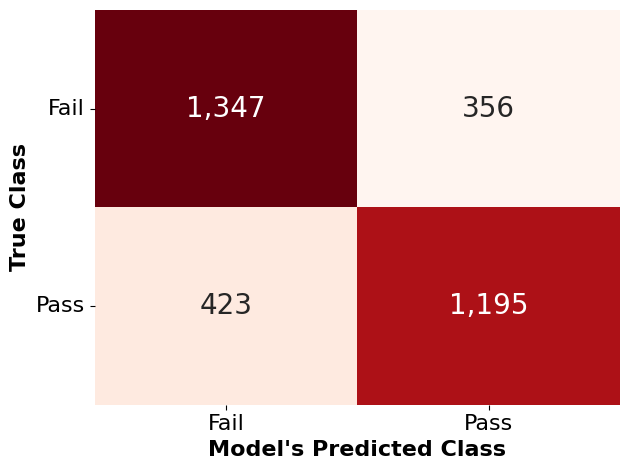

In [94]:
fig, ax = plt.subplots(1, 1)

sns.heatmap(
    confusion_matrix(testY, predict_grades_LR_fit.predict(testX)),
    annot = True,
    fmt = ",d",
    cmap = "Reds",
    cbar = False,
    ax = ax,
    annot_kws = {"size": 20}
)

ax.set_xlabel("Model's Predicted Class", fontweight = "bold", fontsize = 16)
ax.set_xticks(np.arange(0,2,1) + 0.5)
ax.set_xticklabels(["Fail", "Pass"], fontsize = 16)

ax.set_ylabel("True Class", fontweight = "bold", fontsize = 16)
ax.set_yticks(np.arange(0,2,1) + 0.5)
ax.set_yticklabels(["Fail", "Pass"], rotation = 0, fontsize = 16)

plt.tight_layout()
plt.savefig("report_pdf/images/confmatrix.png")

In [95]:
tn, fp, fn, tp = confusion_matrix(testY, predict_grades_LR_fit.predict(testX)).ravel()

accuracy = accuracy_score(testY, predict_grades_LR_fit.predict(testX))
precision = precision_score(testY, predict_grades_LR_fit.predict(testX))
recall = recall_score(testY, predict_grades_LR_fit.predict(testX))
specificity = tn / (tn + fp)
f1_score_ = f1_score(testY, predict_grades_LR_fit.predict(testX))
informedness = (recall + specificity) - 1

print(f"""
Accuracy: {accuracy:.2f}
Precision: {precision:.2f}
Recall: {recall:.2f}
Specificity: {specificity:.2f}
F1 Score: {f1_score_:.2f}
Informedness: {informedness:.2f}
""")


Accuracy: 0.77
Precision: 0.77
Recall: 0.74
Specificity: 0.79
F1 Score: 0.75
Informedness: 0.53



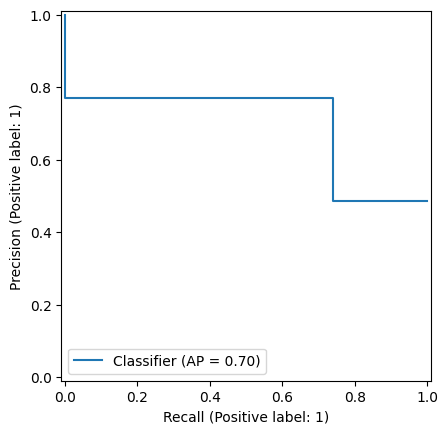

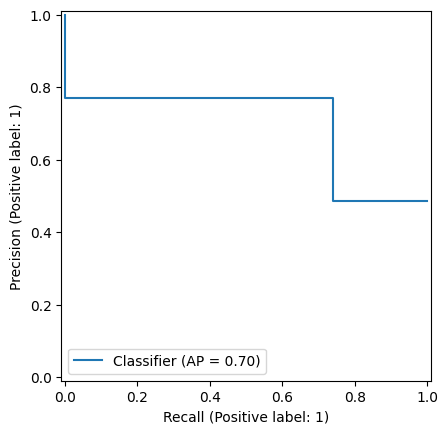

In [96]:
PrecRecall = PrecisionRecallDisplay.from_predictions(testY, predict_grades_LR_fit.predict(testX))

PrecRecall.plot()

plt.savefig("report_pdf/images/precision_recall.png")

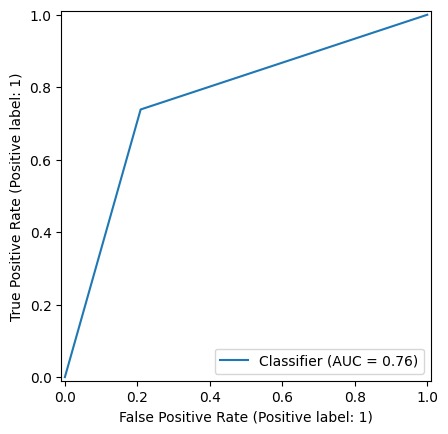

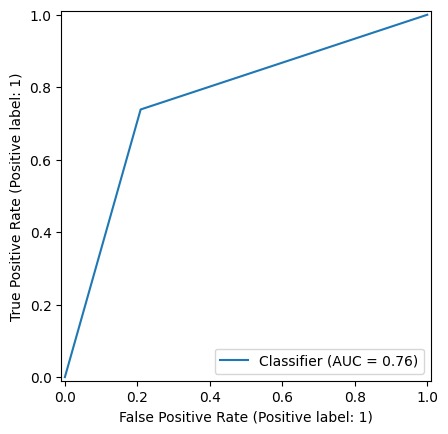

In [97]:
Roc = RocCurveDisplay.from_predictions(testY, predict_grades_LR_fit.predict(testX))

Roc.plot()

plt.savefig("report_pdf/images/roc.png")

Given that we balanced the classes by under-sampling the "pass" subset, it's not too surprising that our model performance metrics are the same for each class.